In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_air_polution_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    cast_to_float,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="date")
    .pipe(set_index, col="date")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_Data, freq="D")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (1825, 7)
dataframe shape (1825, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Freq: D
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1825 non-null   float64
 1   dewp       1825 non-null   float64
 2   temp       1825 non-null   float64
 3   press      1825 non-null   float64
 4   wnd_spd    1825 non-null   float64
 5   snow       1825 non-null   float64
 6   rain       1825 non-null   float64
dtypes: float64(7)
memory usage: 114.1 KB
None


,pollution,dewp,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0


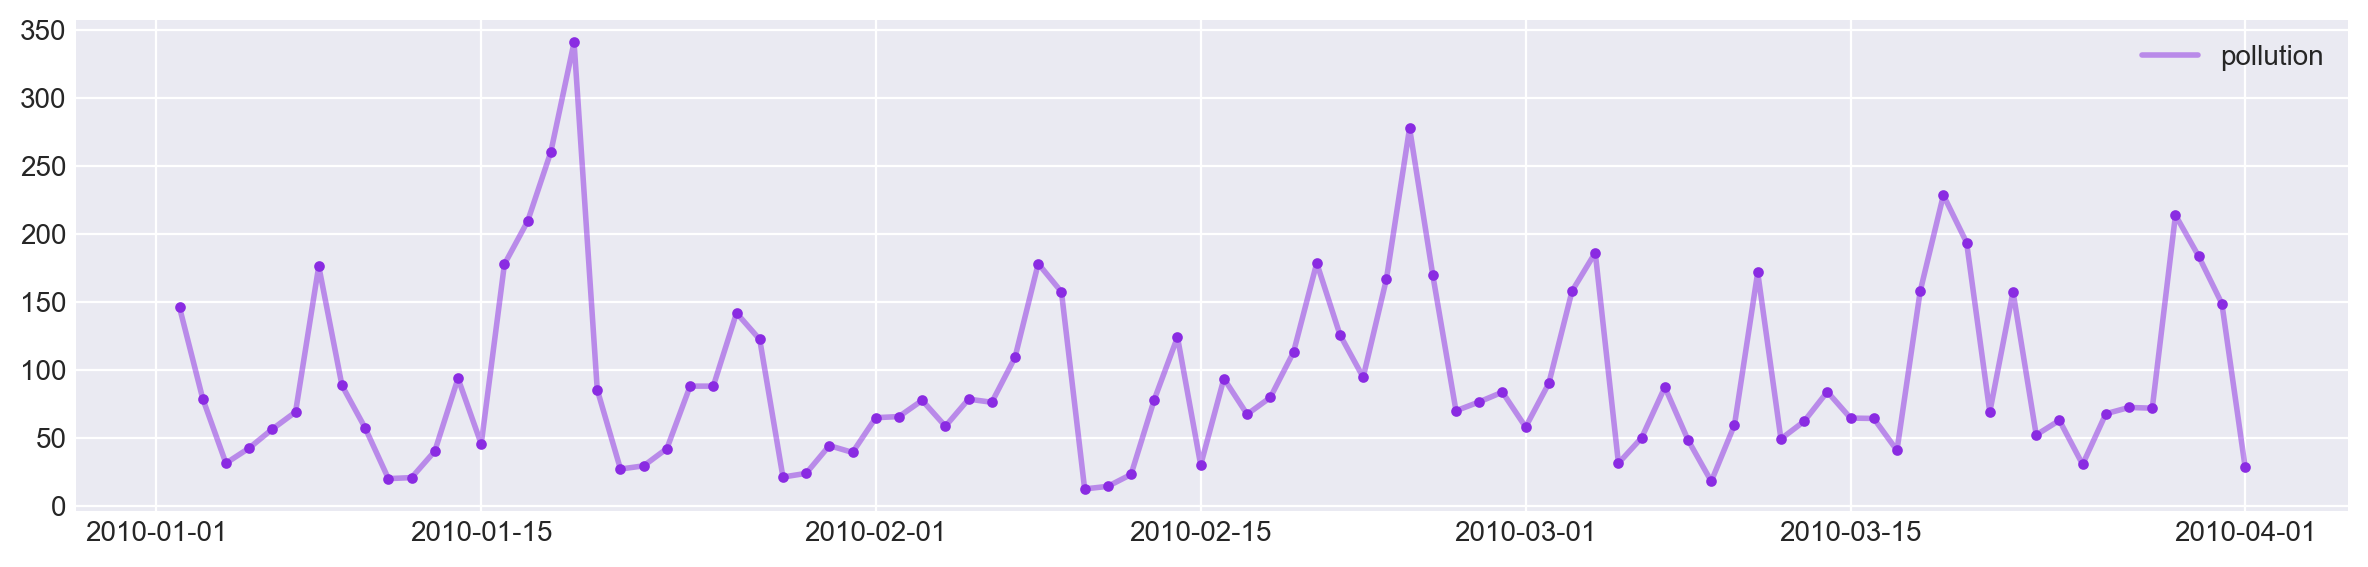

In [4]:
show_dataset(dataframe[:90], columns=["pollution"])

In [5]:
dt_features = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
cl_features = ["day", "month", "year"]
lags = [1, 2]
window_length = 3

target_column = "pollution"
TEST_SIZE = 30

In [6]:
train_data, test_data = test_train_split(dataframe, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)

train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

print(f"train_data shape after Feature Union {train_data_feat.shape}")
print(f"test_data shape after Feature Union {test_data_feat.shape}")

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

print(f"train_data shape after Null Removal {train_data_feat.shape}")
print(f"test_data shape after Null Removal {test_data_feat.shape}")

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

test_data_feat.head()

Train Size after Test_Train Split: (1795, 7)
Test  Size after Test_Train Split: (30, 7) 
train_data shape after Feature Union (1795, 26)
test_data shape after Feature Union (30, 26)
train_data shape after Null Removal (1793, 26)
test_data shape after Null Removal (30, 26)


,pollution,dewp,temp,press,wnd_spd,snow,rain,pollution_lag_1,pollution_lag_2,pollution_mean_window_3,...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
date,,,,,,,,,,,,,,,,,,,,,
2014-12-02,51.791667,-19.500000,-5.000000,1027.833333,38.071250,0.0,0.0,51.791667,51.791667,28.791667,...,2.0,49.0,0.0,1.0,0.909297,-0.416147,-0.536573,0.843854,0.149847,-0.988709
2014-12-03,25.375000,-22.250000,-2.791667,1026.625000,53.080417,0.0,0.0,51.791667,51.791667,28.791667,...,3.0,49.0,0.0,1.0,0.141120,-0.989992,-0.536573,0.843854,-0.751007,-0.660294
2014-12-04,9.208333,-22.416667,-2.000000,1027.375000,60.924583,0.0,0.0,25.375000,51.791667,28.791667,...,4.0,49.0,0.0,1.0,-0.756802,-0.653644,-0.536573,0.843854,-0.961389,0.275192
2014-12-05,36.458333,-20.250000,-2.750000,1027.208333,14.563333,0.0,0.0,9.208333,25.375000,23.680556,...,5.0,49.0,0.0,0.0,-0.958924,0.283662,-0.536573,0.843854,-0.287874,0.957668
2014-12-06,70.541667,-16.541667,-1.958333,1026.291667,4.210833,0.0,0.0,36.458333,9.208333,38.736111,...,6.0,49.0,1.0,0.0,-0.279415,0.960170,-0.536573,0.843854,0.650311,0.759668


In [7]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.116 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.215 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.427 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.148 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.355 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.448 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.234 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.363 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.481 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.271 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.368 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

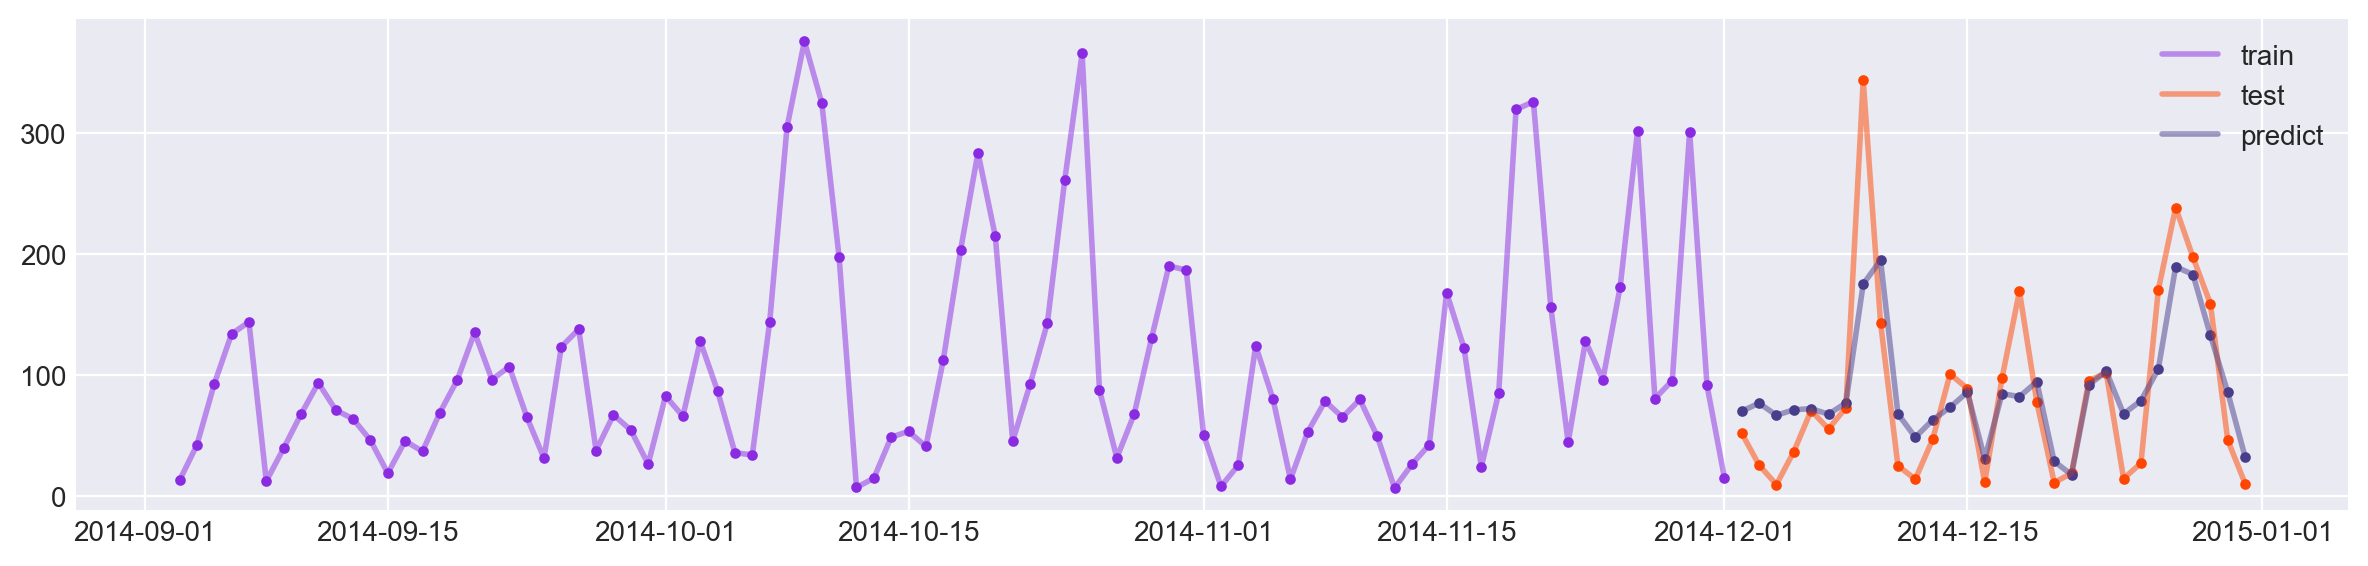

In [9]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [10]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  5  iterations


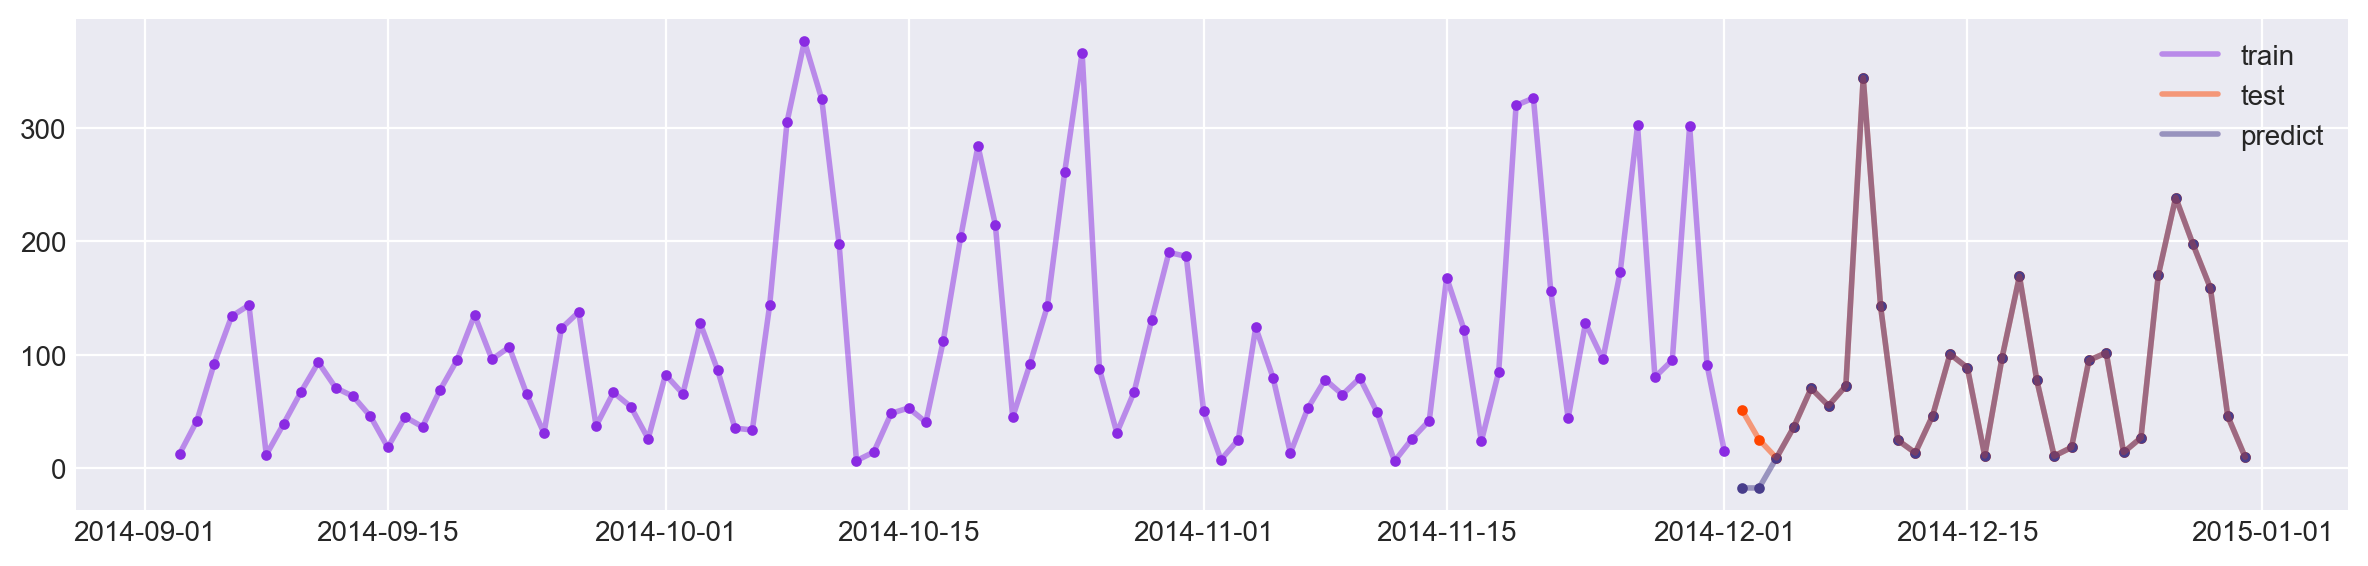

In [11]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [12]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

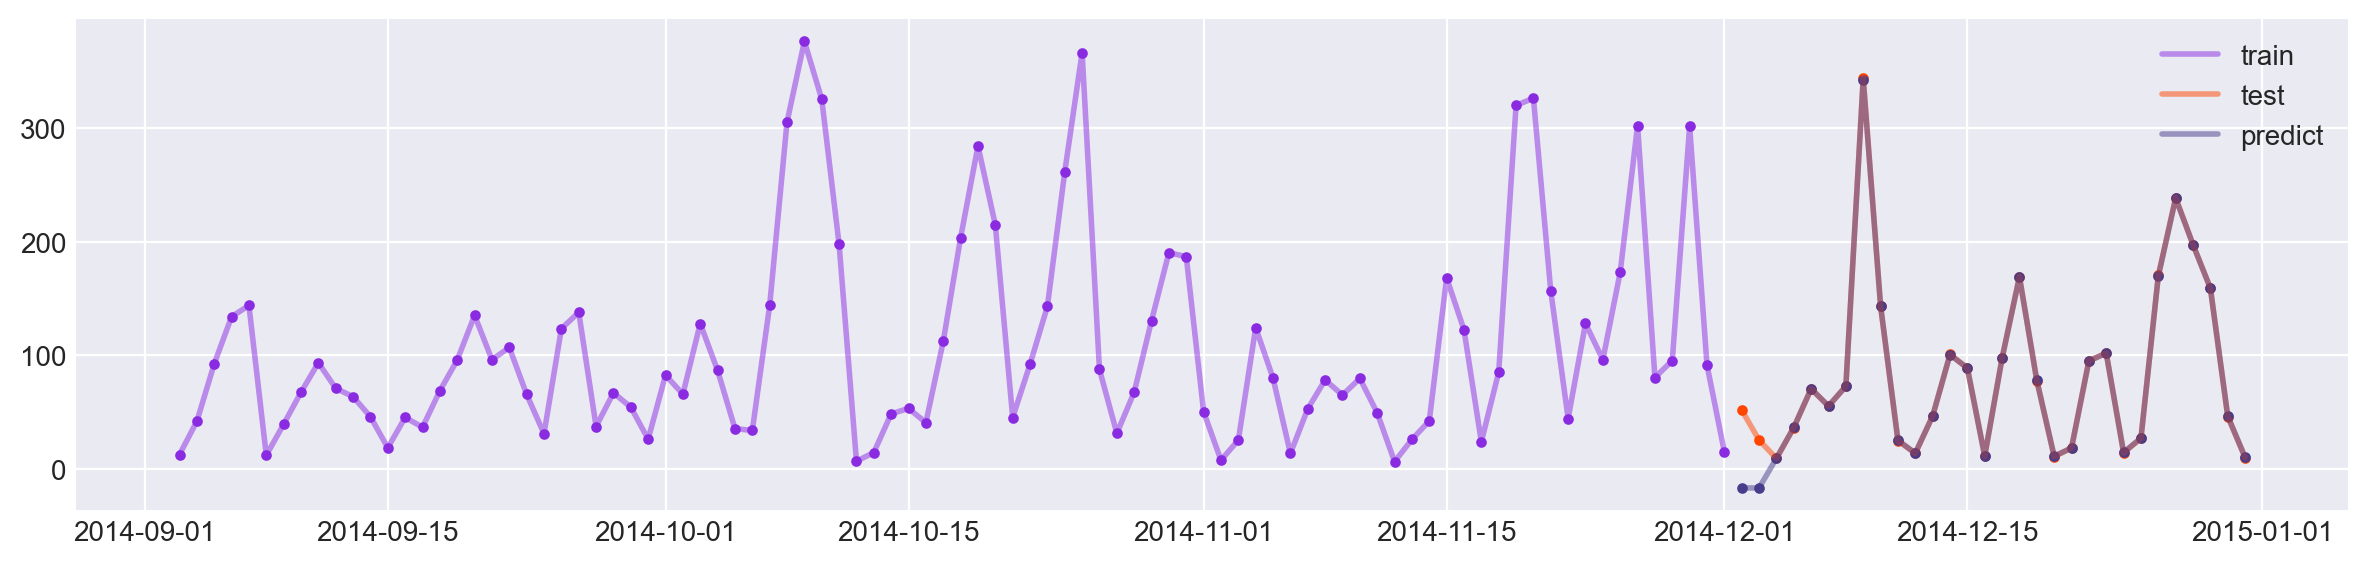

In [13]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# Best Params {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [2],
    "min_samples_split": [7],
    "n_estimators": [500],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())


gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.827 total time=   5.3s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.874 total time=  10.7s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.928 total time=  15.3s
0.8764365037604108 {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}


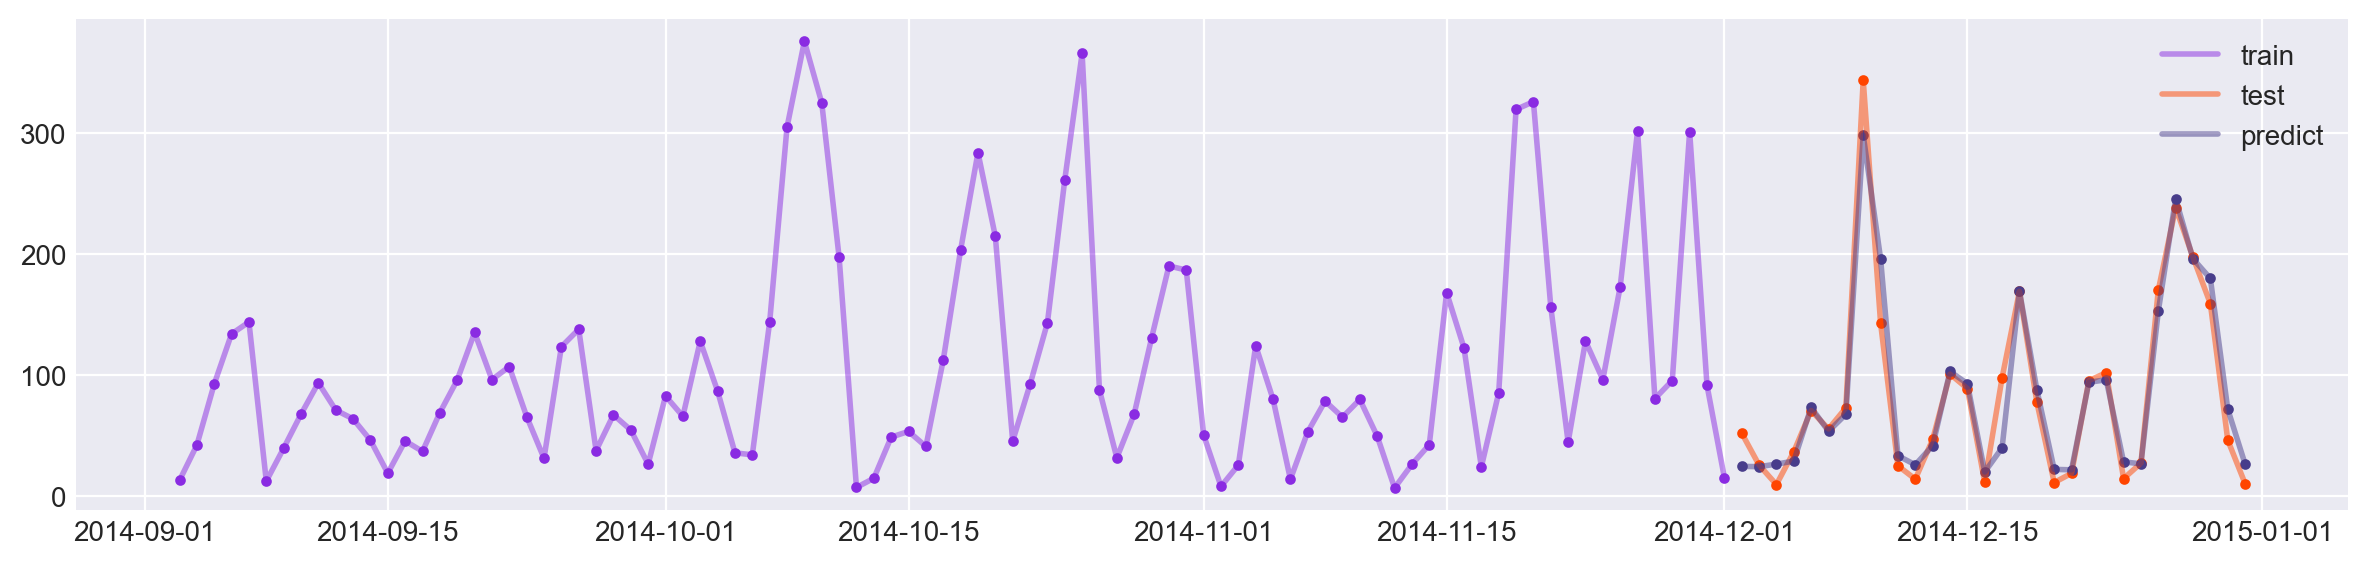

In [15]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:97.47122	validation_1-mae:82.94485
[1]	validation_0-mae:96.51979	validation_1-mae:82.16985
[2]	validation_0-mae:95.57866	validation_1-mae:81.43025
[3]	validation_0-mae:94.64628	validation_1-mae:80.72161
[4]	validation_0-mae:93.72291	validation_1-mae:79.96502
[5]	validation_0-mae:92.80938	validation_1-mae:79.22505
[6]	validation_0-mae:91.90313	validation_1-mae:78.51200
[7]	validation_0-mae:91.00823	validation_1-mae:77.76664
[8]	validation_0-mae:90.12173	validation_1-mae:77.08157
[9]	validation_0-mae:89.24299	validation_1-mae:76.36837
[10]	validation_0-mae:88.37415	validation_1-mae:75.68482
[11]	validation_0-mae:87.51324	validation_1-mae:75.00208
[12]	validation_0-mae:86.66261	validation_1-mae:74.34721
[13]	validation_0-mae:85.81886	validation_1-mae:73.65045
[14]	validation_0-mae:84.98442	validation_1-mae:73.04379
[15]	validation_0-mae:84.15698	validation_1-mae:72.40270
[16]	validation_0-mae:83.33781	validation_1-mae:71.75266
[17]	validation_0-mae:82.52704	validation

[144]	validation_0-mae:25.10384	validation_1-mae:25.76189
[145]	validation_0-mae:24.88541	validation_1-mae:25.59723
[146]	validation_0-mae:24.66803	validation_1-mae:25.42030
[147]	validation_0-mae:24.45386	validation_1-mae:25.25026
[148]	validation_0-mae:24.24180	validation_1-mae:25.07650
[149]	validation_0-mae:24.03122	validation_1-mae:24.87563
[150]	validation_0-mae:23.82018	validation_1-mae:24.69884
[151]	validation_0-mae:23.61020	validation_1-mae:24.54008
[152]	validation_0-mae:23.40513	validation_1-mae:24.33022
[153]	validation_0-mae:23.20267	validation_1-mae:24.18427
[154]	validation_0-mae:22.99995	validation_1-mae:24.03474
[155]	validation_0-mae:22.80390	validation_1-mae:23.88235
[156]	validation_0-mae:22.60474	validation_1-mae:23.69269
[157]	validation_0-mae:22.40914	validation_1-mae:23.50515
[158]	validation_0-mae:22.21329	validation_1-mae:23.34145
[159]	validation_0-mae:22.02098	validation_1-mae:23.15012
[160]	validation_0-mae:21.83697	validation_1-mae:22.99674
[161]	validati

[286]	validation_0-mae:8.63181	validation_1-mae:13.24424
[287]	validation_0-mae:8.58295	validation_1-mae:13.21388
[288]	validation_0-mae:8.53274	validation_1-mae:13.19401
[289]	validation_0-mae:8.48156	validation_1-mae:13.16654
[290]	validation_0-mae:8.43220	validation_1-mae:13.14668
[291]	validation_0-mae:8.38473	validation_1-mae:13.11602
[292]	validation_0-mae:8.33725	validation_1-mae:13.08452
[293]	validation_0-mae:8.28755	validation_1-mae:13.06000
[294]	validation_0-mae:8.24035	validation_1-mae:13.04089
[295]	validation_0-mae:8.19473	validation_1-mae:13.01761
[296]	validation_0-mae:8.14961	validation_1-mae:12.98153
[297]	validation_0-mae:8.10239	validation_1-mae:12.95488
[298]	validation_0-mae:8.05474	validation_1-mae:12.92412
[299]	validation_0-mae:8.01001	validation_1-mae:12.89893
[300]	validation_0-mae:7.96611	validation_1-mae:12.87255
[301]	validation_0-mae:7.91952	validation_1-mae:12.84357
[302]	validation_0-mae:7.87706	validation_1-mae:12.80174
[303]	validation_0-mae:7.83392	

[430]	validation_0-mae:4.42225	validation_1-mae:11.20580
[431]	validation_0-mae:4.40764	validation_1-mae:11.20419
[432]	validation_0-mae:4.39344	validation_1-mae:11.20010
[433]	validation_0-mae:4.37914	validation_1-mae:11.19882
[434]	validation_0-mae:4.36479	validation_1-mae:11.19887
[435]	validation_0-mae:4.35133	validation_1-mae:11.19979
[436]	validation_0-mae:4.33853	validation_1-mae:11.19314
[437]	validation_0-mae:4.32530	validation_1-mae:11.18928
[438]	validation_0-mae:4.31163	validation_1-mae:11.17825
[439]	validation_0-mae:4.29856	validation_1-mae:11.17777
[440]	validation_0-mae:4.28431	validation_1-mae:11.17313
[441]	validation_0-mae:4.26974	validation_1-mae:11.18173
[442]	validation_0-mae:4.25495	validation_1-mae:11.17707
[443]	validation_0-mae:4.24169	validation_1-mae:11.17795
[444]	validation_0-mae:4.22858	validation_1-mae:11.18331
[445]	validation_0-mae:4.21589	validation_1-mae:11.17616
[446]	validation_0-mae:4.20305	validation_1-mae:11.17593
[447]	validation_0-mae:4.19024	

[574]	validation_0-mae:3.16497	validation_1-mae:10.80072
[575]	validation_0-mae:3.15995	validation_1-mae:10.79806
[576]	validation_0-mae:3.15478	validation_1-mae:10.79513
[577]	validation_0-mae:3.15016	validation_1-mae:10.79434
[578]	validation_0-mae:3.14465	validation_1-mae:10.79379
[579]	validation_0-mae:3.14042	validation_1-mae:10.78792
[580]	validation_0-mae:3.13419	validation_1-mae:10.78599
[581]	validation_0-mae:3.12999	validation_1-mae:10.78133
[582]	validation_0-mae:3.12516	validation_1-mae:10.77763
[583]	validation_0-mae:3.11951	validation_1-mae:10.77312
[584]	validation_0-mae:3.11524	validation_1-mae:10.76837
[585]	validation_0-mae:3.11023	validation_1-mae:10.76505
[586]	validation_0-mae:3.10543	validation_1-mae:10.76216
[587]	validation_0-mae:3.10058	validation_1-mae:10.75972
[588]	validation_0-mae:3.09698	validation_1-mae:10.76045
[589]	validation_0-mae:3.09153	validation_1-mae:10.75982
[590]	validation_0-mae:3.08739	validation_1-mae:10.75589
[591]	validation_0-mae:3.08213	

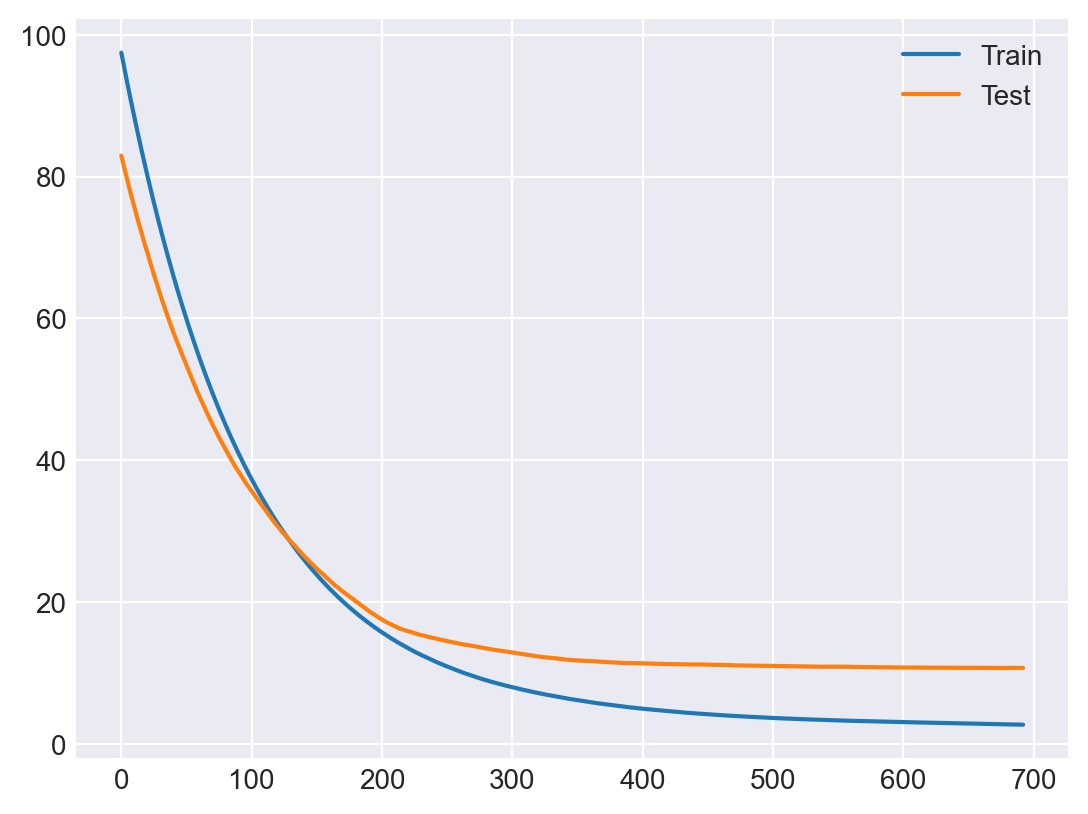

In [16]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

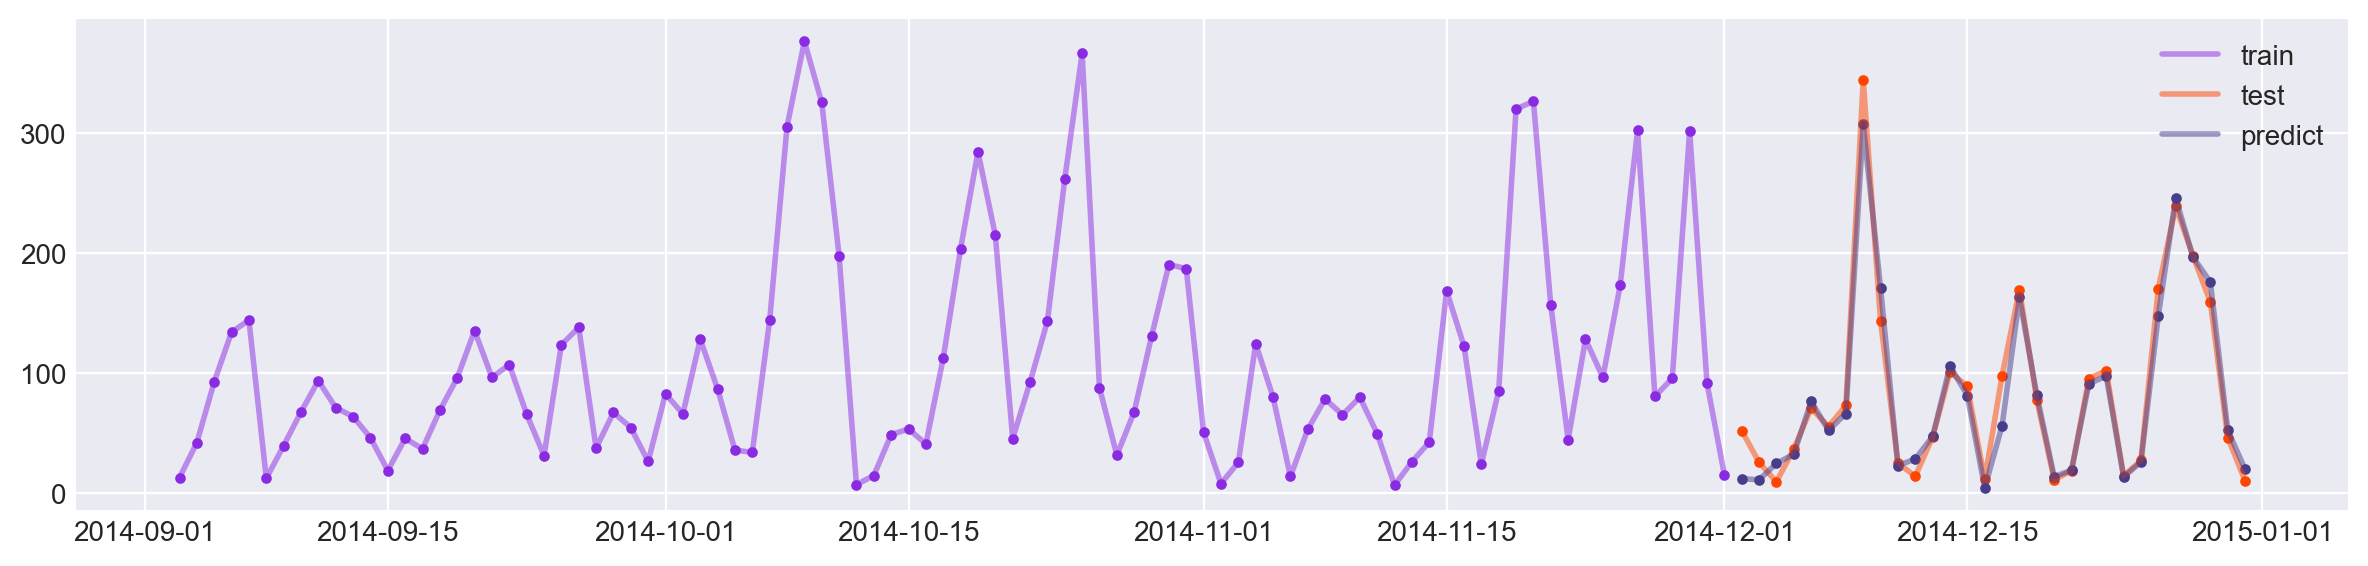

In [17]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [18]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 53.1082	training's l2: 5010.91	valid_1's l1: 58.3351	valid_1's l2: 5354.15
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 48.5325	training's l2: 4211.39	valid_1's l1: 53.3281	valid_1's l2: 4488.46
[3]	training's l1: 44.4674	training's l2: 3555.51	valid_1's l1: 48.404	valid_1's l2: 3734.89
[4]	training's l1: 40.842	training's l2: 3021.89	valid_1's l1: 44.4722	valid_1's l2: 3158.02
[5]	training's l1: 37.5883	training's l2: 2573.08	valid_1's l1: 41.2042	valid_1's l2: 2695.43
[6]	training's l1: 34.6713	training's l2: 2198.86	valid_1's l1: 38.0088	valid_1's l2: 2305.53
[7]	training's l1: 31.9833	training's l2: 1887.66	valid_1's l1: 35.2561	valid_1's l2: 2004.74
[8]	training's l1: 29.5694	training's l2: 1629.54	valid_1's l1: 33.4405	valid_1's l2: 1799.05
[9]	training's l1: 27.2353	training's l2: 1399.61	valid_1's l1: 31.5111	valid_1's l2: 1602.77
[10]	training's l1: 25.291	training's l2: 1218.16	valid_1's l1: 29.348	valid_1's l2: 1410.63


[100]	training's l1: 3.12793	training's l2: 37.748	valid_1's l1: 10.5144	valid_1's l2: 276.066
Did not meet early stopping. Best iteration is:
[100]	training's l1: 3.12793	training's l2: 37.748	valid_1's l1: 10.5144	valid_1's l2: 276.066


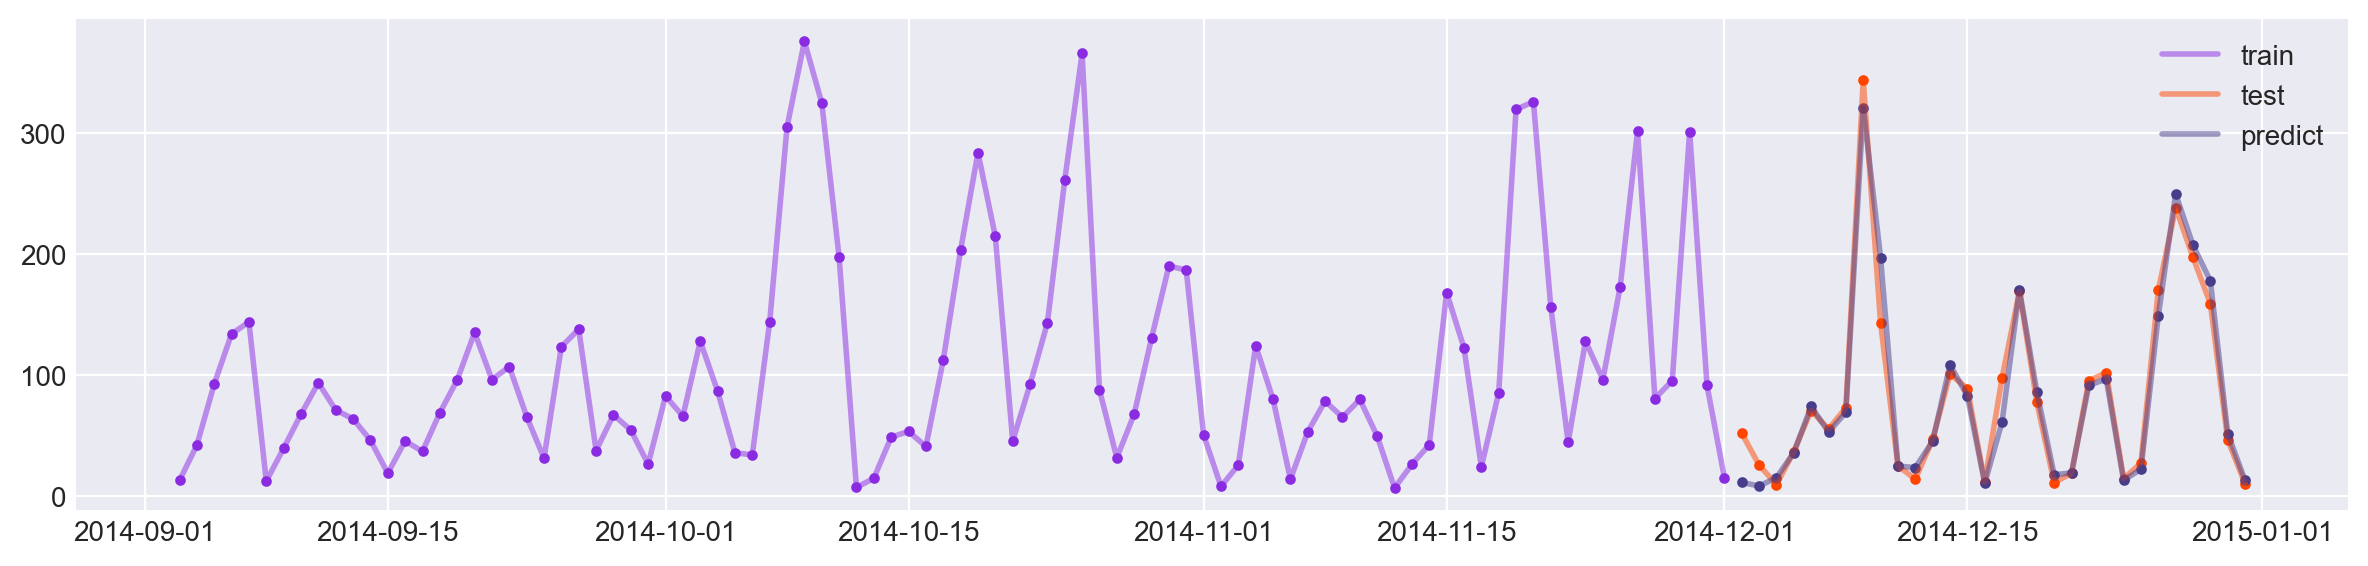

In [19]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [21]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 116.0023739	test: 119.1049068	best: 119.1049068 (0)	total: 4.47ms	remaining: 4.46s
1:	learn: 107.7533087	test: 111.3001596	best: 111.3001596 (1)	total: 9.02ms	remaining: 4.5s
2:	learn: 100.6965248	test: 104.4800831	best: 104.4800831 (2)	total: 12.6ms	remaining: 4.2s
3:	learn: 93.9009571	test: 97.5182963	best: 97.5182963 (3)	total: 23.7ms	remaining: 5.9s
4:	learn: 88.1810350	test: 92.2088035	best: 92.2088035 (4)	total: 39.2ms	remaining: 7.81s
5:	learn: 82.5329786	test: 86.6134786	best: 86.6134786 (5)	total: 54.6ms	remaining: 9.05s
6:	learn: 77.9464609	test: 81.6794534	best: 81.6794534 (6)	total: 69.9ms	remaining: 9.91s
7:	learn: 73.8682618	test: 77.3913678	best: 77.3913678 (7)	total: 83.1ms	remaining: 10.3s
8:	learn: 70.1997873	test: 73.3495197	best: 73.3495197 (8)	total: 96.4ms	remaining: 10.6s
9:	learn: 67.0403162	test: 70.1195494	best: 70.1195494 (9)	total: 125ms	remaining: 12.4s
10:	learn: 64.3327001	test: 67.5296717	best: 67.5296717 (10)	total: 189ms	remaining: 17s
11:	le

91:	learn: 19.5219469	test: 22.5540883	best: 22.5540883 (91)	total: 1.51s	remaining: 14.9s
92:	learn: 19.3447596	test: 22.3625310	best: 22.3625310 (92)	total: 1.51s	remaining: 14.7s
93:	learn: 19.2746672	test: 22.2565328	best: 22.2565328 (93)	total: 1.51s	remaining: 14.6s
94:	learn: 19.1179231	test: 22.1104159	best: 22.1104159 (94)	total: 1.51s	remaining: 14.4s
95:	learn: 18.9653238	test: 21.9516485	best: 21.9516485 (95)	total: 1.52s	remaining: 14.3s
96:	learn: 18.8611642	test: 21.8678794	best: 21.8678794 (96)	total: 1.52s	remaining: 14.1s
97:	learn: 18.7119082	test: 21.7792394	best: 21.7792394 (97)	total: 1.52s	remaining: 14s
98:	learn: 18.5598358	test: 21.6273095	best: 21.6273095 (98)	total: 1.52s	remaining: 13.9s
99:	learn: 18.4255021	test: 21.4502795	best: 21.4502795 (99)	total: 1.52s	remaining: 13.7s
100:	learn: 18.3168693	test: 21.3257988	best: 21.3257988 (100)	total: 1.53s	remaining: 13.6s
101:	learn: 18.1024313	test: 21.0992991	best: 21.0992991 (101)	total: 1.53s	remaining: 13.

183:	learn: 10.7830343	test: 15.8275922	best: 15.8275922 (183)	total: 2.82s	remaining: 12.5s
184:	learn: 10.7160110	test: 15.7755546	best: 15.7755546 (184)	total: 2.83s	remaining: 12.5s
185:	learn: 10.6675099	test: 15.7364114	best: 15.7364114 (185)	total: 2.84s	remaining: 12.4s
186:	learn: 10.6010777	test: 15.6972490	best: 15.6972490 (186)	total: 2.85s	remaining: 12.4s
187:	learn: 10.5562990	test: 15.6756837	best: 15.6756837 (187)	total: 2.87s	remaining: 12.4s
188:	learn: 10.5218139	test: 15.6581531	best: 15.6581531 (188)	total: 2.88s	remaining: 12.4s
189:	learn: 10.4748049	test: 15.6308562	best: 15.6308562 (189)	total: 2.89s	remaining: 12.3s
190:	learn: 10.4200609	test: 15.6109560	best: 15.6109560 (190)	total: 2.93s	remaining: 12.4s
191:	learn: 10.3781329	test: 15.5894197	best: 15.5894197 (191)	total: 2.96s	remaining: 12.4s
192:	learn: 10.3098529	test: 15.5392476	best: 15.5392476 (192)	total: 2.98s	remaining: 12.4s
193:	learn: 10.2745351	test: 15.5075816	best: 15.5075816 (193)	total: 

280:	learn: 7.1248963	test: 13.6804372	best: 13.6804372 (280)	total: 4.53s	remaining: 11.6s
281:	learn: 7.1132125	test: 13.6699328	best: 13.6699328 (281)	total: 4.53s	remaining: 11.5s
282:	learn: 7.0868050	test: 13.6626590	best: 13.6626590 (282)	total: 4.53s	remaining: 11.5s
283:	learn: 7.0692980	test: 13.6644043	best: 13.6626590 (282)	total: 4.54s	remaining: 11.4s
284:	learn: 7.0551303	test: 13.6477201	best: 13.6477201 (284)	total: 4.54s	remaining: 11.4s
285:	learn: 7.0253407	test: 13.6176532	best: 13.6176532 (285)	total: 4.55s	remaining: 11.4s
286:	learn: 6.9939958	test: 13.6100010	best: 13.6100010 (286)	total: 4.57s	remaining: 11.3s
287:	learn: 6.9574915	test: 13.5717484	best: 13.5717484 (287)	total: 4.58s	remaining: 11.3s
288:	learn: 6.9340119	test: 13.5615690	best: 13.5615690 (288)	total: 4.59s	remaining: 11.3s
289:	learn: 6.9056244	test: 13.5522039	best: 13.5522039 (289)	total: 4.62s	remaining: 11.3s
290:	learn: 6.8761327	test: 13.5428763	best: 13.5428763 (290)	total: 4.65s	remai

380:	learn: 5.2947682	test: 12.8000472	best: 12.8000472 (380)	total: 6.24s	remaining: 10.1s
381:	learn: 5.2848755	test: 12.7819833	best: 12.7819833 (381)	total: 6.24s	remaining: 10.1s
382:	learn: 5.2697687	test: 12.7774371	best: 12.7774371 (382)	total: 6.25s	remaining: 10.1s
383:	learn: 5.2595561	test: 12.7709676	best: 12.7709676 (383)	total: 6.25s	remaining: 10s
384:	learn: 5.2437631	test: 12.7699598	best: 12.7699598 (384)	total: 6.25s	remaining: 9.99s
385:	learn: 5.2337591	test: 12.7678213	best: 12.7678213 (385)	total: 6.25s	remaining: 9.95s
386:	learn: 5.2160610	test: 12.7617337	best: 12.7617337 (386)	total: 6.26s	remaining: 9.91s
387:	learn: 5.2006461	test: 12.7630617	best: 12.7617337 (386)	total: 6.26s	remaining: 9.88s
388:	learn: 5.1849440	test: 12.7526398	best: 12.7526398 (388)	total: 6.26s	remaining: 9.84s
389:	learn: 5.1722635	test: 12.7439126	best: 12.7439126 (389)	total: 6.27s	remaining: 9.8s
390:	learn: 5.1576643	test: 12.7410614	best: 12.7410614 (390)	total: 6.27s	remainin

475:	learn: 4.2492452	test: 12.4487782	best: 12.4487782 (475)	total: 7.52s	remaining: 8.28s
476:	learn: 4.2350053	test: 12.4435782	best: 12.4435782 (476)	total: 7.54s	remaining: 8.27s
477:	learn: 4.2307944	test: 12.4330560	best: 12.4330560 (477)	total: 7.57s	remaining: 8.27s
478:	learn: 4.2180143	test: 12.4306059	best: 12.4306059 (478)	total: 7.58s	remaining: 8.25s
479:	learn: 4.2093315	test: 12.4165155	best: 12.4165155 (479)	total: 7.6s	remaining: 8.23s
480:	learn: 4.1967742	test: 12.4166694	best: 12.4165155 (479)	total: 7.63s	remaining: 8.23s
481:	learn: 4.1839194	test: 12.4132054	best: 12.4132054 (481)	total: 7.65s	remaining: 8.22s
482:	learn: 4.1755265	test: 12.4133378	best: 12.4132054 (481)	total: 7.68s	remaining: 8.22s
483:	learn: 4.1655437	test: 12.4129561	best: 12.4129561 (483)	total: 7.7s	remaining: 8.21s
484:	learn: 4.1591328	test: 12.4141321	best: 12.4129561 (483)	total: 7.71s	remaining: 8.19s
485:	learn: 4.1566501	test: 12.4153985	best: 12.4129561 (483)	total: 7.72s	remaini

571:	learn: 3.5621086	test: 12.2946167	best: 12.2909130 (563)	total: 9.21s	remaining: 6.89s
572:	learn: 3.5568396	test: 12.2942986	best: 12.2909130 (563)	total: 9.22s	remaining: 6.87s
573:	learn: 3.5518802	test: 12.2933802	best: 12.2909130 (563)	total: 9.23s	remaining: 6.85s
574:	learn: 3.5447021	test: 12.2921847	best: 12.2909130 (563)	total: 9.26s	remaining: 6.85s
575:	learn: 3.5371483	test: 12.2972540	best: 12.2909130 (563)	total: 9.29s	remaining: 6.84s
576:	learn: 3.5290978	test: 12.2930043	best: 12.2909130 (563)	total: 9.31s	remaining: 6.82s
577:	learn: 3.5225004	test: 12.2889411	best: 12.2889411 (577)	total: 9.33s	remaining: 6.81s
578:	learn: 3.5156676	test: 12.2821405	best: 12.2821405 (578)	total: 9.34s	remaining: 6.79s
579:	learn: 3.5124942	test: 12.2786319	best: 12.2786319 (579)	total: 9.36s	remaining: 6.78s
580:	learn: 3.5079771	test: 12.2795752	best: 12.2786319 (579)	total: 9.39s	remaining: 6.77s
581:	learn: 3.5039027	test: 12.2699495	best: 12.2699495 (581)	total: 9.42s	remai

667:	learn: 3.0305176	test: 12.2202856	best: 12.2157184 (664)	total: 10.7s	remaining: 5.31s
668:	learn: 3.0277297	test: 12.2190077	best: 12.2157184 (664)	total: 10.7s	remaining: 5.29s
669:	learn: 3.0199370	test: 12.2201051	best: 12.2157184 (664)	total: 10.7s	remaining: 5.27s
670:	learn: 3.0160378	test: 12.2220249	best: 12.2157184 (664)	total: 10.7s	remaining: 5.25s
671:	learn: 3.0096809	test: 12.2213278	best: 12.2157184 (664)	total: 10.7s	remaining: 5.22s
672:	learn: 3.0045606	test: 12.2214127	best: 12.2157184 (664)	total: 10.7s	remaining: 5.2s
673:	learn: 3.0007387	test: 12.2218234	best: 12.2157184 (664)	total: 10.7s	remaining: 5.18s
674:	learn: 2.9972997	test: 12.2192507	best: 12.2157184 (664)	total: 10.7s	remaining: 5.16s
675:	learn: 2.9932836	test: 12.2165533	best: 12.2157184 (664)	total: 10.7s	remaining: 5.13s
676:	learn: 2.9882859	test: 12.2162953	best: 12.2157184 (664)	total: 10.7s	remaining: 5.11s
677:	learn: 2.9832164	test: 12.2127514	best: 12.2127514 (677)	total: 10.8s	remain

770:	learn: 2.6038236	test: 12.1603131	best: 12.1543917 (730)	total: 12.2s	remaining: 3.61s
771:	learn: 2.6001682	test: 12.1626773	best: 12.1543917 (730)	total: 12.2s	remaining: 3.59s
772:	learn: 2.5965973	test: 12.1632464	best: 12.1543917 (730)	total: 12.2s	remaining: 3.57s
773:	learn: 2.5923972	test: 12.1643065	best: 12.1543917 (730)	total: 12.2s	remaining: 3.55s
774:	learn: 2.5874766	test: 12.1632025	best: 12.1543917 (730)	total: 12.2s	remaining: 3.54s
775:	learn: 2.5848245	test: 12.1626113	best: 12.1543917 (730)	total: 12.2s	remaining: 3.52s
776:	learn: 2.5800814	test: 12.1619013	best: 12.1543917 (730)	total: 12.2s	remaining: 3.51s
777:	learn: 2.5754789	test: 12.1598136	best: 12.1543917 (730)	total: 12.3s	remaining: 3.5s
778:	learn: 2.5712517	test: 12.1570511	best: 12.1543917 (730)	total: 12.3s	remaining: 3.48s
779:	learn: 2.5691682	test: 12.1562726	best: 12.1543917 (730)	total: 12.3s	remaining: 3.47s
780:	learn: 2.5671819	test: 12.1562964	best: 12.1543917 (730)	total: 12.3s	remain

862:	learn: 2.2939004	test: 12.0859299	best: 12.0859299 (862)	total: 13.7s	remaining: 2.17s
863:	learn: 2.2904485	test: 12.0869028	best: 12.0859299 (862)	total: 13.7s	remaining: 2.15s
864:	learn: 2.2879822	test: 12.0871841	best: 12.0859299 (862)	total: 13.7s	remaining: 2.14s
865:	learn: 2.2846992	test: 12.0883894	best: 12.0859299 (862)	total: 13.7s	remaining: 2.12s
866:	learn: 2.2813417	test: 12.0882648	best: 12.0859299 (862)	total: 13.7s	remaining: 2.1s
867:	learn: 2.2780759	test: 12.0893831	best: 12.0859299 (862)	total: 13.7s	remaining: 2.09s
868:	learn: 2.2759029	test: 12.0885144	best: 12.0859299 (862)	total: 13.8s	remaining: 2.07s
869:	learn: 2.2728632	test: 12.0889416	best: 12.0859299 (862)	total: 13.8s	remaining: 2.06s
870:	learn: 2.2684227	test: 12.0913139	best: 12.0859299 (862)	total: 13.8s	remaining: 2.04s
871:	learn: 2.2653537	test: 12.0925930	best: 12.0859299 (862)	total: 13.8s	remaining: 2.03s
872:	learn: 2.2622882	test: 12.0914208	best: 12.0859299 (862)	total: 13.8s	remain

960:	learn: 2.0383200	test: 12.0314795	best: 12.0295403 (952)	total: 14.9s	remaining: 605ms
961:	learn: 2.0371692	test: 12.0303514	best: 12.0295403 (952)	total: 14.9s	remaining: 590ms
962:	learn: 2.0344031	test: 12.0290256	best: 12.0290256 (962)	total: 14.9s	remaining: 574ms
963:	learn: 2.0298416	test: 12.0263795	best: 12.0263795 (963)	total: 14.9s	remaining: 558ms
964:	learn: 2.0271710	test: 12.0240024	best: 12.0240024 (964)	total: 15s	remaining: 543ms
965:	learn: 2.0254883	test: 12.0246365	best: 12.0240024 (964)	total: 15s	remaining: 527ms
966:	learn: 2.0251418	test: 12.0252183	best: 12.0240024 (964)	total: 15s	remaining: 511ms
967:	learn: 2.0226962	test: 12.0241989	best: 12.0240024 (964)	total: 15s	remaining: 496ms
968:	learn: 2.0197965	test: 12.0265219	best: 12.0240024 (964)	total: 15s	remaining: 480ms
969:	learn: 2.0167181	test: 12.0264605	best: 12.0240024 (964)	total: 15s	remaining: 465ms
970:	learn: 2.0124115	test: 12.0271044	best: 12.0240024 (964)	total: 15.1s	remaining: 450ms


51:	learn: 29.1809939	test: 31.4778556	best: 31.4778556 (51)	total: 853ms	remaining: 15.5s
52:	learn: 28.9461436	test: 31.1974826	best: 31.1974826 (52)	total: 869ms	remaining: 15.5s
53:	learn: 28.7040706	test: 30.9691951	best: 30.9691951 (53)	total: 885ms	remaining: 15.5s
54:	learn: 28.4527167	test: 30.7342461	best: 30.7342461 (54)	total: 939ms	remaining: 16.1s
55:	learn: 28.3584993	test: 30.7106402	best: 30.7106402 (55)	total: 969ms	remaining: 16.3s
56:	learn: 28.2674320	test: 30.6474877	best: 30.6474877 (56)	total: 993ms	remaining: 16.4s
57:	learn: 27.9995743	test: 30.4236004	best: 30.4236004 (57)	total: 1.01s	remaining: 16.4s
58:	learn: 27.8186398	test: 30.2522406	best: 30.2522406 (58)	total: 1.02s	remaining: 16.3s
59:	learn: 27.6187784	test: 30.0159023	best: 30.0159023 (59)	total: 1.03s	remaining: 16.2s
60:	learn: 27.4220303	test: 29.8782034	best: 29.8782034 (60)	total: 1.06s	remaining: 16.3s
61:	learn: 27.1399481	test: 29.6158177	best: 29.6158177 (61)	total: 1.08s	remaining: 16.4s

149:	learn: 14.1670942	test: 18.8355134	best: 18.8355134 (149)	total: 2.78s	remaining: 15.7s
150:	learn: 14.0535729	test: 18.7524584	best: 18.7524584 (150)	total: 2.8s	remaining: 15.8s
151:	learn: 13.9996013	test: 18.7572737	best: 18.7524584 (150)	total: 2.81s	remaining: 15.7s
152:	learn: 13.9658948	test: 18.7662497	best: 18.7524584 (150)	total: 2.83s	remaining: 15.7s
153:	learn: 13.9408751	test: 18.7354381	best: 18.7354381 (153)	total: 2.87s	remaining: 15.8s
154:	learn: 13.8314254	test: 18.6448365	best: 18.6448365 (154)	total: 2.9s	remaining: 15.8s
155:	learn: 13.7302603	test: 18.5909459	best: 18.5909459 (155)	total: 2.92s	remaining: 15.8s
156:	learn: 13.6415013	test: 18.5169445	best: 18.5169445 (156)	total: 2.94s	remaining: 15.8s
157:	learn: 13.5956388	test: 18.4691089	best: 18.4691089 (157)	total: 2.95s	remaining: 15.7s
158:	learn: 13.5438700	test: 18.4497040	best: 18.4497040 (158)	total: 2.97s	remaining: 15.7s
159:	learn: 13.4505925	test: 18.3662640	best: 18.3662640 (159)	total: 2.

244:	learn: 9.0858302	test: 15.7869420	best: 15.7784777 (243)	total: 4.5s	remaining: 13.9s
245:	learn: 9.0300375	test: 15.7727667	best: 15.7727667 (245)	total: 4.53s	remaining: 13.9s
246:	learn: 8.9873082	test: 15.7124053	best: 15.7124053 (246)	total: 4.55s	remaining: 13.9s
247:	learn: 8.9699230	test: 15.7189061	best: 15.7124053 (246)	total: 4.56s	remaining: 13.8s
248:	learn: 8.9231181	test: 15.6784381	best: 15.6784381 (248)	total: 4.57s	remaining: 13.8s
249:	learn: 8.8844729	test: 15.6378319	best: 15.6378319 (249)	total: 4.59s	remaining: 13.8s
250:	learn: 8.8634673	test: 15.6296156	best: 15.6296156 (250)	total: 4.6s	remaining: 13.7s
251:	learn: 8.8224712	test: 15.6070255	best: 15.6070255 (251)	total: 4.62s	remaining: 13.7s
252:	learn: 8.7843853	test: 15.5895083	best: 15.5895083 (252)	total: 4.63s	remaining: 13.7s
253:	learn: 8.7594858	test: 15.5739855	best: 15.5739855 (253)	total: 4.64s	remaining: 13.6s
254:	learn: 8.7444152	test: 15.5705759	best: 15.5705759 (254)	total: 4.67s	remaini

339:	learn: 6.7020874	test: 14.4567846	best: 14.4567846 (339)	total: 6.01s	remaining: 11.7s
340:	learn: 6.6708135	test: 14.4343496	best: 14.4343496 (340)	total: 6.01s	remaining: 11.6s
341:	learn: 6.6505149	test: 14.4192138	best: 14.4192138 (341)	total: 6.02s	remaining: 11.6s
342:	learn: 6.6279645	test: 14.4070513	best: 14.4070513 (342)	total: 6.02s	remaining: 11.5s
343:	learn: 6.6091081	test: 14.3912469	best: 14.3912469 (343)	total: 6.02s	remaining: 11.5s
344:	learn: 6.5842845	test: 14.3812552	best: 14.3812552 (344)	total: 6.03s	remaining: 11.4s
345:	learn: 6.5580990	test: 14.3679477	best: 14.3679477 (345)	total: 6.03s	remaining: 11.4s
346:	learn: 6.5403506	test: 14.3522194	best: 14.3522194 (346)	total: 6.03s	remaining: 11.4s
347:	learn: 6.5171220	test: 14.3321133	best: 14.3321133 (347)	total: 6.1s	remaining: 11.4s
348:	learn: 6.5014621	test: 14.3169964	best: 14.3169964 (348)	total: 6.12s	remaining: 11.4s
349:	learn: 6.4862998	test: 14.2900538	best: 14.2900538 (349)	total: 6.13s	remain

433:	learn: 5.1743693	test: 13.7985516	best: 13.7985516 (433)	total: 7.55s	remaining: 9.85s
434:	learn: 5.1595892	test: 13.7854756	best: 13.7854756 (434)	total: 7.56s	remaining: 9.82s
435:	learn: 5.1447409	test: 13.7815555	best: 13.7815555 (435)	total: 7.57s	remaining: 9.8s
436:	learn: 5.1301621	test: 13.7767772	best: 13.7767772 (436)	total: 7.59s	remaining: 9.78s
437:	learn: 5.1177148	test: 13.7686257	best: 13.7686257 (437)	total: 7.6s	remaining: 9.75s
438:	learn: 5.1028569	test: 13.7609031	best: 13.7609031 (438)	total: 7.63s	remaining: 9.75s
439:	learn: 5.0843135	test: 13.7706984	best: 13.7609031 (438)	total: 7.65s	remaining: 9.74s
440:	learn: 5.0756697	test: 13.7619241	best: 13.7609031 (438)	total: 7.67s	remaining: 9.72s
441:	learn: 5.0737835	test: 13.7609214	best: 13.7609031 (438)	total: 7.68s	remaining: 9.69s
442:	learn: 5.0719547	test: 13.7598013	best: 13.7598013 (442)	total: 7.69s	remaining: 9.66s
443:	learn: 5.0574922	test: 13.7556893	best: 13.7556893 (443)	total: 7.7s	remainin

524:	learn: 4.2813018	test: 13.5081058	best: 13.5054790 (523)	total: 9.04s	remaining: 8.18s
525:	learn: 4.2764406	test: 13.5093282	best: 13.5054790 (523)	total: 9.07s	remaining: 8.17s
526:	learn: 4.2667992	test: 13.5056547	best: 13.5054790 (523)	total: 9.1s	remaining: 8.16s
527:	learn: 4.2551645	test: 13.5000912	best: 13.5000912 (527)	total: 9.12s	remaining: 8.15s
528:	learn: 4.2448729	test: 13.4966562	best: 13.4966562 (528)	total: 9.13s	remaining: 8.13s
529:	learn: 4.2384899	test: 13.4922825	best: 13.4922825 (529)	total: 9.15s	remaining: 8.11s
530:	learn: 4.2297990	test: 13.4915474	best: 13.4915474 (530)	total: 9.16s	remaining: 8.09s
531:	learn: 4.2252793	test: 13.4870064	best: 13.4870064 (531)	total: 9.18s	remaining: 8.07s
532:	learn: 4.2140889	test: 13.4846997	best: 13.4846997 (532)	total: 9.19s	remaining: 8.05s
533:	learn: 4.2064076	test: 13.4785380	best: 13.4785380 (533)	total: 9.2s	remaining: 8.03s
534:	learn: 4.2017419	test: 13.4775718	best: 13.4775718 (534)	total: 9.2s	remainin

616:	learn: 3.6346893	test: 13.3210550	best: 13.3210550 (616)	total: 10.3s	remaining: 6.4s
617:	learn: 3.6328527	test: 13.3267050	best: 13.3210550 (616)	total: 10.3s	remaining: 6.37s
618:	learn: 3.6289830	test: 13.3256359	best: 13.3210550 (616)	total: 10.3s	remaining: 6.35s
619:	learn: 3.6200410	test: 13.3192920	best: 13.3192920 (619)	total: 10.3s	remaining: 6.32s
620:	learn: 3.6150000	test: 13.3144366	best: 13.3144366 (620)	total: 10.3s	remaining: 6.3s
621:	learn: 3.6103080	test: 13.3053318	best: 13.3053318 (621)	total: 10.3s	remaining: 6.27s
622:	learn: 3.6060250	test: 13.2963021	best: 13.2963021 (622)	total: 10.3s	remaining: 6.26s
623:	learn: 3.5995815	test: 13.2926119	best: 13.2926119 (623)	total: 10.4s	remaining: 6.25s
624:	learn: 3.5986639	test: 13.2929221	best: 13.2926119 (623)	total: 10.4s	remaining: 6.24s
625:	learn: 3.5933151	test: 13.2932842	best: 13.2926119 (623)	total: 10.4s	remaining: 6.22s
626:	learn: 3.5890209	test: 13.2923462	best: 13.2923462 (626)	total: 10.4s	remaini

723:	learn: 3.1336723	test: 13.1166737	best: 13.1142582 (721)	total: 12s	remaining: 4.56s
724:	learn: 3.1286110	test: 13.1188216	best: 13.1142582 (721)	total: 12s	remaining: 4.54s
725:	learn: 3.1236192	test: 13.1185304	best: 13.1142582 (721)	total: 12s	remaining: 4.52s
726:	learn: 3.1172814	test: 13.1135729	best: 13.1135729 (726)	total: 12s	remaining: 4.5s
727:	learn: 3.1144958	test: 13.1146218	best: 13.1135729 (726)	total: 12s	remaining: 4.47s
728:	learn: 3.1128104	test: 13.1147196	best: 13.1135729 (726)	total: 12s	remaining: 4.45s
729:	learn: 3.1086267	test: 13.1144358	best: 13.1135729 (726)	total: 12s	remaining: 4.43s
730:	learn: 3.1048201	test: 13.1123766	best: 13.1123766 (730)	total: 12s	remaining: 4.41s
731:	learn: 3.1041703	test: 13.1122762	best: 13.1122762 (731)	total: 12s	remaining: 4.39s
732:	learn: 3.0992489	test: 13.1146907	best: 13.1122762 (731)	total: 12s	remaining: 4.37s
733:	learn: 3.0951551	test: 13.1109693	best: 13.1109693 (733)	total: 12s	remaining: 4.35s
734:	learn:

818:	learn: 2.7679712	test: 13.0416025	best: 13.0416025 (818)	total: 13.2s	remaining: 2.92s
819:	learn: 2.7625184	test: 13.0403630	best: 13.0403630 (819)	total: 13.2s	remaining: 2.9s
820:	learn: 2.7586690	test: 13.0402741	best: 13.0402741 (820)	total: 13.2s	remaining: 2.88s
821:	learn: 2.7539775	test: 13.0407589	best: 13.0402741 (820)	total: 13.2s	remaining: 2.87s
822:	learn: 2.7527082	test: 13.0401284	best: 13.0401284 (822)	total: 13.2s	remaining: 2.85s
823:	learn: 2.7478659	test: 13.0377395	best: 13.0377395 (823)	total: 13.2s	remaining: 2.83s
824:	learn: 2.7444115	test: 13.0372824	best: 13.0372824 (824)	total: 13.2s	remaining: 2.81s
825:	learn: 2.7407569	test: 13.0362077	best: 13.0362077 (825)	total: 13.2s	remaining: 2.79s
826:	learn: 2.7375165	test: 13.0368205	best: 13.0362077 (825)	total: 13.2s	remaining: 2.77s
827:	learn: 2.7358670	test: 13.0363657	best: 13.0362077 (825)	total: 13.3s	remaining: 2.75s
828:	learn: 2.7325820	test: 13.0351133	best: 13.0351133 (828)	total: 13.3s	remain

908:	learn: 2.4952962	test: 12.9868042	best: 12.9860648 (881)	total: 14.5s	remaining: 1.45s
909:	learn: 2.4906748	test: 12.9884737	best: 12.9860648 (881)	total: 14.5s	remaining: 1.44s
910:	learn: 2.4865630	test: 12.9900742	best: 12.9860648 (881)	total: 14.5s	remaining: 1.42s
911:	learn: 2.4830391	test: 12.9899258	best: 12.9860648 (881)	total: 14.5s	remaining: 1.4s
912:	learn: 2.4806494	test: 12.9959787	best: 12.9860648 (881)	total: 14.6s	remaining: 1.39s
913:	learn: 2.4790795	test: 12.9933021	best: 12.9860648 (881)	total: 14.6s	remaining: 1.37s
914:	learn: 2.4749643	test: 12.9931273	best: 12.9860648 (881)	total: 14.6s	remaining: 1.35s
915:	learn: 2.4724805	test: 12.9927548	best: 12.9860648 (881)	total: 14.6s	remaining: 1.34s
916:	learn: 2.4686434	test: 12.9920987	best: 12.9860648 (881)	total: 14.6s	remaining: 1.32s
917:	learn: 2.4673167	test: 12.9927711	best: 12.9860648 (881)	total: 14.6s	remaining: 1.31s
918:	learn: 2.4628204	test: 12.9955583	best: 12.9860648 (881)	total: 14.7s	remain

998:	learn: 2.2596026	test: 12.9675217	best: 12.9658717 (992)	total: 16s	remaining: 16ms
999:	learn: 2.2572255	test: 12.9651891	best: 12.9651891 (999)	total: 16s	remaining: 0us

bestTest = 12.96518907
bestIteration = 999

1:	loss: 12.9651891	best: 12.0191074 (0)	total: 31.8s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 118.0193031	test: 113.4698662	best: 113.4698662 (0)	total: 11.4ms	remaining: 11.3s
1:	learn: 110.7395730	test: 106.4317001	best: 106.4317001 (1)	total: 27.3ms	remaining: 13.6s
2:	learn: 103.5711109	test: 99.9554742	best: 99.9554742 (2)	total: 42.4ms	remaining: 14.1s
3:	learn: 97.0056707	test: 93.2741163	best: 93.2741163 (3)	total: 54.4ms	remaining: 13.5s
4:	learn: 90.8271640	test: 87.9085756	best: 87.9085756 (4)	total: 68.1ms	remaining: 13.6s
5:	learn: 85.1884463	test: 82.5670756	best: 82.5670756 (5)	total: 84.8ms	remaining: 14s
6:	learn: 80.5936512	test: 78.5689661	best: 78.5689661 (6)	total: 118ms	remaining: 16.7s
7:	learn: 76.0672865	tes

92:	learn: 20.6541227	test: 24.7208938	best: 24.7208938 (92)	total: 1.61s	remaining: 15.7s
93:	learn: 20.4313974	test: 24.5298468	best: 24.5298468 (93)	total: 1.61s	remaining: 15.5s
94:	learn: 20.3063617	test: 24.4861914	best: 24.4861914 (94)	total: 1.61s	remaining: 15.4s
95:	learn: 20.1282934	test: 24.3550837	best: 24.3550837 (95)	total: 1.61s	remaining: 15.2s
96:	learn: 19.9710567	test: 24.2172785	best: 24.2172785 (96)	total: 1.62s	remaining: 15.1s
97:	learn: 19.7784067	test: 24.0802442	best: 24.0802442 (97)	total: 1.62s	remaining: 14.9s
98:	learn: 19.6379855	test: 24.0470196	best: 24.0470196 (98)	total: 1.62s	remaining: 14.8s
99:	learn: 19.4858404	test: 23.9399253	best: 23.9399253 (99)	total: 1.63s	remaining: 14.6s
100:	learn: 19.3812167	test: 23.8591890	best: 23.8591890 (100)	total: 1.63s	remaining: 14.5s
101:	learn: 19.2381774	test: 23.7376622	best: 23.7376622 (101)	total: 1.64s	remaining: 14.5s
102:	learn: 18.9993923	test: 23.5176211	best: 23.5176211 (102)	total: 1.66s	remaining:

185:	learn: 11.2143470	test: 17.5585414	best: 17.5585414 (185)	total: 2.91s	remaining: 12.7s
186:	learn: 11.1561054	test: 17.5088891	best: 17.5088891 (186)	total: 2.94s	remaining: 12.8s
187:	learn: 11.1143344	test: 17.4925243	best: 17.4925243 (187)	total: 2.96s	remaining: 12.8s
188:	learn: 11.0381041	test: 17.4539423	best: 17.4539423 (188)	total: 2.98s	remaining: 12.8s
189:	learn: 11.0050318	test: 17.4679752	best: 17.4539423 (188)	total: 2.99s	remaining: 12.8s
190:	learn: 10.9449210	test: 17.4348085	best: 17.4348085 (190)	total: 3.01s	remaining: 12.7s
191:	learn: 10.8880786	test: 17.4096790	best: 17.4096790 (191)	total: 3.02s	remaining: 12.7s
192:	learn: 10.8643849	test: 17.4049582	best: 17.4049582 (192)	total: 3.04s	remaining: 12.7s
193:	learn: 10.8030237	test: 17.3743040	best: 17.3743040 (193)	total: 3.05s	remaining: 12.7s
194:	learn: 10.7620224	test: 17.3494143	best: 17.3494143 (194)	total: 3.07s	remaining: 12.7s
195:	learn: 10.7216742	test: 17.3256480	best: 17.3256480 (195)	total: 

287:	learn: 7.3279855	test: 15.0703377	best: 15.0703377 (287)	total: 4.59s	remaining: 11.3s
288:	learn: 7.3152365	test: 15.0707624	best: 15.0703377 (287)	total: 4.59s	remaining: 11.3s
289:	learn: 7.2825738	test: 15.0529437	best: 15.0529437 (289)	total: 4.59s	remaining: 11.2s
290:	learn: 7.2567616	test: 15.0433585	best: 15.0433585 (290)	total: 4.6s	remaining: 11.2s
291:	learn: 7.2327196	test: 15.0462648	best: 15.0433585 (290)	total: 4.6s	remaining: 11.2s
292:	learn: 7.1973155	test: 15.0343536	best: 15.0343536 (292)	total: 4.6s	remaining: 11.1s
293:	learn: 7.1703167	test: 15.0445620	best: 15.0343536 (292)	total: 4.61s	remaining: 11.1s
294:	learn: 7.1456402	test: 15.0254602	best: 15.0254602 (294)	total: 4.61s	remaining: 11s
295:	learn: 7.1158533	test: 14.9986716	best: 14.9986716 (295)	total: 4.64s	remaining: 11s
296:	learn: 7.1007997	test: 14.9890683	best: 14.9890683 (296)	total: 4.67s	remaining: 11.1s
297:	learn: 7.0741741	test: 14.9741584	best: 14.9741584 (297)	total: 4.7s	remaining: 11

387:	learn: 5.3185615	test: 13.9869358	best: 13.9869358 (387)	total: 6.28s	remaining: 9.9s
388:	learn: 5.3002042	test: 13.9833121	best: 13.9833121 (388)	total: 6.28s	remaining: 9.87s
389:	learn: 5.2868376	test: 13.9756498	best: 13.9756498 (389)	total: 6.29s	remaining: 9.84s
390:	learn: 5.2802817	test: 13.9809050	best: 13.9756498 (389)	total: 6.3s	remaining: 9.81s
391:	learn: 5.2671366	test: 13.9748566	best: 13.9748566 (391)	total: 6.33s	remaining: 9.81s
392:	learn: 5.2464961	test: 13.9684772	best: 13.9684772 (392)	total: 6.36s	remaining: 9.82s
393:	learn: 5.2380659	test: 13.9551235	best: 13.9551235 (393)	total: 6.38s	remaining: 9.82s
394:	learn: 5.2207049	test: 13.9470330	best: 13.9470330 (394)	total: 6.4s	remaining: 9.81s
395:	learn: 5.2129401	test: 13.9450152	best: 13.9450152 (395)	total: 6.42s	remaining: 9.79s
396:	learn: 5.1976210	test: 13.9372430	best: 13.9372430 (396)	total: 6.43s	remaining: 9.76s
397:	learn: 5.1867215	test: 13.9296408	best: 13.9296408 (397)	total: 6.44s	remainin

483:	learn: 4.1812091	test: 13.4485857	best: 13.4485857 (483)	total: 8.04s	remaining: 8.57s
484:	learn: 4.1685678	test: 13.4430602	best: 13.4430602 (484)	total: 8.04s	remaining: 8.54s
485:	learn: 4.1637646	test: 13.4365738	best: 13.4365738 (485)	total: 8.04s	remaining: 8.51s
486:	learn: 4.1576064	test: 13.4304933	best: 13.4304933 (486)	total: 8.05s	remaining: 8.48s
487:	learn: 4.1482044	test: 13.4269904	best: 13.4269904 (487)	total: 8.05s	remaining: 8.45s
488:	learn: 4.1387598	test: 13.4211098	best: 13.4211098 (488)	total: 8.06s	remaining: 8.43s
489:	learn: 4.1328496	test: 13.4200880	best: 13.4200880 (489)	total: 8.09s	remaining: 8.42s
490:	learn: 4.1285099	test: 13.4184988	best: 13.4184988 (490)	total: 8.12s	remaining: 8.41s
491:	learn: 4.1206102	test: 13.4160547	best: 13.4160547 (491)	total: 8.15s	remaining: 8.41s
492:	learn: 4.1158331	test: 13.4159126	best: 13.4159126 (492)	total: 8.16s	remaining: 8.4s
493:	learn: 4.1074148	test: 13.4109558	best: 13.4109558 (493)	total: 8.18s	remain

577:	learn: 3.4199408	test: 13.1230742	best: 13.1230742 (577)	total: 9.56s	remaining: 6.98s
578:	learn: 3.4151278	test: 13.1226056	best: 13.1226056 (578)	total: 9.56s	remaining: 6.96s
579:	learn: 3.4041075	test: 13.1191952	best: 13.1191952 (579)	total: 9.57s	remaining: 6.93s
580:	learn: 3.3912562	test: 13.1246775	best: 13.1191952 (579)	total: 9.57s	remaining: 6.9s
581:	learn: 3.3841313	test: 13.1128962	best: 13.1128962 (581)	total: 9.57s	remaining: 6.88s
582:	learn: 3.3745824	test: 13.1164181	best: 13.1128962 (581)	total: 9.57s	remaining: 6.85s
583:	learn: 3.3691654	test: 13.1119063	best: 13.1119063 (583)	total: 9.58s	remaining: 6.82s
584:	learn: 3.3627981	test: 13.1088900	best: 13.1088900 (584)	total: 9.58s	remaining: 6.79s
585:	learn: 3.3548183	test: 13.1076698	best: 13.1076698 (585)	total: 9.58s	remaining: 6.77s
586:	learn: 3.3434170	test: 13.1035894	best: 13.1035894 (586)	total: 9.58s	remaining: 6.74s
587:	learn: 3.3401732	test: 13.0986183	best: 13.0986183 (587)	total: 9.63s	remain

674:	learn: 2.8718213	test: 12.9314605	best: 12.9314605 (674)	total: 11.1s	remaining: 5.34s
675:	learn: 2.8632153	test: 12.9313680	best: 12.9313680 (675)	total: 11.1s	remaining: 5.32s
676:	learn: 2.8588671	test: 12.9293373	best: 12.9293373 (676)	total: 11.1s	remaining: 5.31s
677:	learn: 2.8517516	test: 12.9267663	best: 12.9267663 (677)	total: 11.1s	remaining: 5.29s
678:	learn: 2.8466931	test: 12.9287414	best: 12.9267663 (677)	total: 11.2s	remaining: 5.27s
679:	learn: 2.8410389	test: 12.9278532	best: 12.9267663 (677)	total: 11.2s	remaining: 5.25s
680:	learn: 2.8314397	test: 12.9302208	best: 12.9267663 (677)	total: 11.2s	remaining: 5.25s
681:	learn: 2.8255008	test: 12.9232126	best: 12.9232126 (681)	total: 11.2s	remaining: 5.23s
682:	learn: 2.8206705	test: 12.9191722	best: 12.9191722 (682)	total: 11.3s	remaining: 5.22s
683:	learn: 2.8192719	test: 12.9193501	best: 12.9191722 (682)	total: 11.3s	remaining: 5.21s
684:	learn: 2.8166079	test: 12.9187371	best: 12.9187371 (684)	total: 11.3s	remai

769:	learn: 2.4534264	test: 12.7977850	best: 12.7949297 (768)	total: 12.8s	remaining: 3.82s
770:	learn: 2.4498017	test: 12.7973958	best: 12.7949297 (768)	total: 12.8s	remaining: 3.8s
771:	learn: 2.4453992	test: 12.7944653	best: 12.7944653 (771)	total: 12.8s	remaining: 3.78s
772:	learn: 2.4391934	test: 12.7912671	best: 12.7912671 (772)	total: 12.8s	remaining: 3.76s
773:	learn: 2.4326548	test: 12.7882004	best: 12.7882004 (773)	total: 12.8s	remaining: 3.74s
774:	learn: 2.4287780	test: 12.7873269	best: 12.7873269 (774)	total: 12.8s	remaining: 3.72s
775:	learn: 2.4244798	test: 12.7883004	best: 12.7873269 (774)	total: 12.8s	remaining: 3.71s
776:	learn: 2.4210855	test: 12.7877198	best: 12.7873269 (774)	total: 12.8s	remaining: 3.69s
777:	learn: 2.4187116	test: 12.7848692	best: 12.7848692 (777)	total: 12.9s	remaining: 3.67s
778:	learn: 2.4145721	test: 12.7838444	best: 12.7838444 (778)	total: 12.9s	remaining: 3.66s
779:	learn: 2.4120109	test: 12.7826674	best: 12.7826674 (779)	total: 12.9s	remain

866:	learn: 2.1434314	test: 12.7040594	best: 12.7040594 (866)	total: 14.5s	remaining: 2.22s
867:	learn: 2.1402108	test: 12.7007326	best: 12.7007326 (867)	total: 14.5s	remaining: 2.2s
868:	learn: 2.1383891	test: 12.7005690	best: 12.7005690 (868)	total: 14.5s	remaining: 2.18s
869:	learn: 2.1354091	test: 12.7011310	best: 12.7005690 (868)	total: 14.5s	remaining: 2.16s
870:	learn: 2.1315835	test: 12.6989798	best: 12.6989798 (870)	total: 14.5s	remaining: 2.15s
871:	learn: 2.1274014	test: 12.6989499	best: 12.6989499 (871)	total: 14.5s	remaining: 2.13s
872:	learn: 2.1224998	test: 12.6942032	best: 12.6942032 (872)	total: 14.5s	remaining: 2.11s
873:	learn: 2.1196146	test: 12.6893234	best: 12.6893234 (873)	total: 14.5s	remaining: 2.09s
874:	learn: 2.1172256	test: 12.6893188	best: 12.6893188 (874)	total: 14.5s	remaining: 2.07s
875:	learn: 2.1146108	test: 12.6895779	best: 12.6893188 (874)	total: 14.5s	remaining: 2.05s
876:	learn: 2.1114691	test: 12.6889774	best: 12.6889774 (876)	total: 14.5s	remain

973:	learn: 1.8811517	test: 12.6419955	best: 12.6417949 (972)	total: 16.4s	remaining: 437ms
974:	learn: 1.8792222	test: 12.6418264	best: 12.6417949 (972)	total: 16.4s	remaining: 420ms
975:	learn: 1.8768833	test: 12.6415446	best: 12.6415446 (975)	total: 16.4s	remaining: 404ms
976:	learn: 1.8739295	test: 12.6429532	best: 12.6415446 (975)	total: 16.4s	remaining: 387ms
977:	learn: 1.8707738	test: 12.6438174	best: 12.6415446 (975)	total: 16.5s	remaining: 370ms
978:	learn: 1.8697088	test: 12.6431925	best: 12.6415446 (975)	total: 16.5s	remaining: 353ms
979:	learn: 1.8667517	test: 12.6431006	best: 12.6415446 (975)	total: 16.5s	remaining: 336ms
980:	learn: 1.8638934	test: 12.6425837	best: 12.6415446 (975)	total: 16.5s	remaining: 320ms
981:	learn: 1.8611633	test: 12.6426756	best: 12.6415446 (975)	total: 16.5s	remaining: 303ms
982:	learn: 1.8573599	test: 12.6432339	best: 12.6415446 (975)	total: 16.5s	remaining: 286ms
983:	learn: 1.8547246	test: 12.6426236	best: 12.6415446 (975)	total: 16.6s	remai

62:	learn: 24.3746105	test: 33.8879110	best: 33.8879110 (62)	total: 1.08s	remaining: 16.1s
63:	learn: 24.3216020	test: 33.8013426	best: 33.8013426 (63)	total: 1.08s	remaining: 15.9s
64:	learn: 24.1200280	test: 33.6302712	best: 33.6302712 (64)	total: 1.09s	remaining: 15.6s
65:	learn: 23.9405540	test: 33.5213304	best: 33.5213304 (65)	total: 1.09s	remaining: 15.4s
66:	learn: 23.7491435	test: 33.3346513	best: 33.3346513 (66)	total: 1.09s	remaining: 15.2s
67:	learn: 23.5385603	test: 33.1908409	best: 33.1908409 (67)	total: 1.1s	remaining: 15.1s
68:	learn: 23.2677506	test: 32.9530049	best: 32.9530049 (68)	total: 1.1s	remaining: 14.9s
69:	learn: 22.9808934	test: 32.7725934	best: 32.7725934 (69)	total: 1.11s	remaining: 14.8s
70:	learn: 22.8552715	test: 32.7472395	best: 32.7472395 (70)	total: 1.14s	remaining: 14.9s
71:	learn: 22.5793257	test: 32.4886105	best: 32.4886105 (71)	total: 1.16s	remaining: 15s
72:	learn: 22.3497669	test: 32.2850160	best: 32.2850160 (72)	total: 1.17s	remaining: 14.9s
73:

165:	learn: 11.3445760	test: 23.9556211	best: 23.9556211 (165)	total: 2.53s	remaining: 12.7s
166:	learn: 11.2971337	test: 23.8992086	best: 23.8992086 (166)	total: 2.55s	remaining: 12.7s
167:	learn: 11.2397954	test: 23.8613112	best: 23.8613112 (167)	total: 2.56s	remaining: 12.7s
168:	learn: 11.1743690	test: 23.8114482	best: 23.8114482 (168)	total: 2.57s	remaining: 12.6s
169:	learn: 11.1300732	test: 23.7557386	best: 23.7557386 (169)	total: 2.58s	remaining: 12.6s
170:	learn: 11.0607351	test: 23.7006531	best: 23.7006531 (170)	total: 2.58s	remaining: 12.5s
171:	learn: 11.0054174	test: 23.6151853	best: 23.6151853 (171)	total: 2.59s	remaining: 12.5s
172:	learn: 10.9493412	test: 23.5677919	best: 23.5677919 (172)	total: 2.6s	remaining: 12.4s
173:	learn: 10.8943028	test: 23.5455453	best: 23.5455453 (173)	total: 2.61s	remaining: 12.4s
174:	learn: 10.8041862	test: 23.5010700	best: 23.5010700 (174)	total: 2.63s	remaining: 12.4s
175:	learn: 10.7515904	test: 23.4682493	best: 23.4682493 (175)	total: 2

257:	learn: 7.5532058	test: 21.2545505	best: 21.2545505 (257)	total: 4s	remaining: 11.5s
258:	learn: 7.5209369	test: 21.2447353	best: 21.2447353 (258)	total: 4.03s	remaining: 11.5s
259:	learn: 7.4833948	test: 21.2167709	best: 21.2167709 (259)	total: 4.05s	remaining: 11.5s
260:	learn: 7.4465309	test: 21.2041057	best: 21.2041057 (260)	total: 4.06s	remaining: 11.5s
261:	learn: 7.4236801	test: 21.1900643	best: 21.1900643 (261)	total: 4.09s	remaining: 11.5s
262:	learn: 7.3900008	test: 21.1681838	best: 21.1681838 (262)	total: 4.12s	remaining: 11.5s
263:	learn: 7.3855530	test: 21.1654973	best: 21.1654973 (263)	total: 4.14s	remaining: 11.6s
264:	learn: 7.3659509	test: 21.1554757	best: 21.1554757 (264)	total: 4.16s	remaining: 11.5s
265:	learn: 7.3606930	test: 21.1553354	best: 21.1553354 (265)	total: 4.18s	remaining: 11.5s
266:	learn: 7.3230427	test: 21.1441447	best: 21.1441447 (266)	total: 4.19s	remaining: 11.5s
267:	learn: 7.3010692	test: 21.1350313	best: 21.1350313 (267)	total: 4.21s	remainin

347:	learn: 5.6719409	test: 20.2430340	best: 20.2430340 (347)	total: 5.52s	remaining: 10.3s
348:	learn: 5.6554630	test: 20.2353331	best: 20.2353331 (348)	total: 5.55s	remaining: 10.4s
349:	learn: 5.6465030	test: 20.2357693	best: 20.2353331 (348)	total: 5.57s	remaining: 10.3s
350:	learn: 5.6312073	test: 20.2111084	best: 20.2111084 (350)	total: 5.59s	remaining: 10.3s
351:	learn: 5.6159411	test: 20.1984931	best: 20.1984931 (351)	total: 5.6s	remaining: 10.3s
352:	learn: 5.6029616	test: 20.1990915	best: 20.1984931 (351)	total: 5.61s	remaining: 10.3s
353:	learn: 5.6003834	test: 20.2010957	best: 20.1984931 (351)	total: 5.63s	remaining: 10.3s
354:	learn: 5.5837657	test: 20.1949201	best: 20.1949201 (354)	total: 5.66s	remaining: 10.3s
355:	learn: 5.5713114	test: 20.1924597	best: 20.1924597 (355)	total: 5.69s	remaining: 10.3s
356:	learn: 5.5507743	test: 20.1754705	best: 20.1754705 (356)	total: 5.72s	remaining: 10.3s
357:	learn: 5.5416598	test: 20.1753526	best: 20.1753526 (357)	total: 5.75s	remain

443:	learn: 4.4812078	test: 19.7331993	best: 19.7329407 (442)	total: 7.23s	remaining: 9.05s
444:	learn: 4.4752774	test: 19.7315750	best: 19.7315750 (444)	total: 7.25s	remaining: 9.05s
445:	learn: 4.4665127	test: 19.7275956	best: 19.7275956 (445)	total: 7.27s	remaining: 9.03s
446:	learn: 4.4549461	test: 19.7250180	best: 19.7250180 (446)	total: 7.29s	remaining: 9.02s
447:	learn: 4.4440991	test: 19.7252094	best: 19.7250180 (446)	total: 7.3s	remaining: 8.99s
448:	learn: 4.4306480	test: 19.7207588	best: 19.7207588 (448)	total: 7.31s	remaining: 8.97s
449:	learn: 4.4274562	test: 19.7203680	best: 19.7203680 (449)	total: 7.32s	remaining: 8.95s
450:	learn: 4.4131854	test: 19.7121151	best: 19.7121151 (450)	total: 7.33s	remaining: 8.93s
451:	learn: 4.4076095	test: 19.7110873	best: 19.7110873 (451)	total: 7.36s	remaining: 8.92s
452:	learn: 4.4029449	test: 19.7123569	best: 19.7110873 (451)	total: 7.38s	remaining: 8.92s
453:	learn: 4.3889610	test: 19.7062412	best: 19.7062412 (453)	total: 7.41s	remain

543:	learn: 3.6165689	test: 19.4147113	best: 19.4147113 (543)	total: 8.73s	remaining: 7.32s
544:	learn: 3.6109719	test: 19.4139736	best: 19.4139736 (544)	total: 8.76s	remaining: 7.32s
545:	learn: 3.6052131	test: 19.4125071	best: 19.4125071 (545)	total: 8.78s	remaining: 7.3s
546:	learn: 3.5975408	test: 19.4119387	best: 19.4119387 (546)	total: 8.8s	remaining: 7.29s
547:	learn: 3.5960722	test: 19.4111481	best: 19.4111481 (547)	total: 8.82s	remaining: 7.27s
548:	learn: 3.5870931	test: 19.4076808	best: 19.4076808 (548)	total: 8.83s	remaining: 7.26s
549:	learn: 3.5805423	test: 19.4037664	best: 19.4037664 (549)	total: 8.84s	remaining: 7.24s
550:	learn: 3.5738496	test: 19.4035202	best: 19.4035202 (550)	total: 8.86s	remaining: 7.22s
551:	learn: 3.5673884	test: 19.4022772	best: 19.4022772 (551)	total: 8.88s	remaining: 7.2s
552:	learn: 3.5617238	test: 19.3982796	best: 19.3982796 (552)	total: 8.9s	remaining: 7.2s
553:	learn: 3.5554529	test: 19.3948809	best: 19.3948809 (553)	total: 8.93s	remaining:

633:	learn: 3.0508730	test: 19.2240806	best: 19.2240806 (633)	total: 10.3s	remaining: 5.94s
634:	learn: 3.0471816	test: 19.2245408	best: 19.2240806 (633)	total: 10.3s	remaining: 5.93s
635:	learn: 3.0420171	test: 19.2207658	best: 19.2207658 (635)	total: 10.3s	remaining: 5.92s
636:	learn: 3.0355874	test: 19.2160643	best: 19.2160643 (636)	total: 10.4s	remaining: 5.91s
637:	learn: 3.0296221	test: 19.2157972	best: 19.2157972 (637)	total: 10.4s	remaining: 5.89s
638:	learn: 3.0252638	test: 19.2177881	best: 19.2157972 (637)	total: 10.4s	remaining: 5.87s
639:	learn: 3.0199617	test: 19.2191264	best: 19.2157972 (637)	total: 10.4s	remaining: 5.85s
640:	learn: 3.0143290	test: 19.2152313	best: 19.2152313 (640)	total: 10.4s	remaining: 5.83s
641:	learn: 3.0076371	test: 19.2167053	best: 19.2152313 (640)	total: 10.4s	remaining: 5.82s
642:	learn: 3.0053467	test: 19.2159221	best: 19.2152313 (640)	total: 10.5s	remaining: 5.81s
643:	learn: 2.9997991	test: 19.2132297	best: 19.2132297 (643)	total: 10.5s	remai

731:	learn: 2.5887798	test: 19.0722070	best: 19.0722070 (731)	total: 11.8s	remaining: 4.34s
732:	learn: 2.5862267	test: 19.0676480	best: 19.0676480 (732)	total: 11.8s	remaining: 4.32s
733:	learn: 2.5812259	test: 19.0666979	best: 19.0666979 (733)	total: 11.8s	remaining: 4.29s
734:	learn: 2.5758557	test: 19.0672006	best: 19.0666979 (733)	total: 11.9s	remaining: 4.27s
735:	learn: 2.5700945	test: 19.0643821	best: 19.0643821 (735)	total: 11.9s	remaining: 4.25s
736:	learn: 2.5658672	test: 19.0659191	best: 19.0643821 (735)	total: 11.9s	remaining: 4.23s
737:	learn: 2.5597347	test: 19.0641006	best: 19.0641006 (737)	total: 11.9s	remaining: 4.21s
738:	learn: 2.5579971	test: 19.0635780	best: 19.0635780 (738)	total: 11.9s	remaining: 4.19s
739:	learn: 2.5568785	test: 19.0630553	best: 19.0630553 (739)	total: 11.9s	remaining: 4.17s
740:	learn: 2.5521019	test: 19.0606964	best: 19.0606964 (740)	total: 11.9s	remaining: 4.15s
741:	learn: 2.5513848	test: 19.0602642	best: 19.0602642 (741)	total: 11.9s	remai

823:	learn: 2.2156472	test: 18.9375289	best: 18.9375289 (823)	total: 13.3s	remaining: 2.85s
824:	learn: 2.2130016	test: 18.9369571	best: 18.9369571 (824)	total: 13.3s	remaining: 2.83s
825:	learn: 2.2100193	test: 18.9352281	best: 18.9352281 (825)	total: 13.3s	remaining: 2.81s
826:	learn: 2.2063690	test: 18.9340523	best: 18.9340523 (826)	total: 13.3s	remaining: 2.79s
827:	learn: 2.2027500	test: 18.9335353	best: 18.9335353 (827)	total: 13.4s	remaining: 2.78s
828:	learn: 2.1979045	test: 18.9319756	best: 18.9319756 (828)	total: 13.4s	remaining: 2.76s
829:	learn: 2.1942473	test: 18.9350426	best: 18.9319756 (828)	total: 13.4s	remaining: 2.74s
830:	learn: 2.1895891	test: 18.9320268	best: 18.9319756 (828)	total: 13.4s	remaining: 2.73s
831:	learn: 2.1877755	test: 18.9314428	best: 18.9314428 (831)	total: 13.4s	remaining: 2.71s
832:	learn: 2.1833986	test: 18.9324843	best: 18.9314428 (831)	total: 13.5s	remaining: 2.7s
833:	learn: 2.1829972	test: 18.9329171	best: 18.9314428 (831)	total: 13.5s	remain

913:	learn: 1.9588117	test: 18.8904666	best: 18.8889075 (910)	total: 14.8s	remaining: 1.4s
914:	learn: 1.9559986	test: 18.8916619	best: 18.8889075 (910)	total: 14.9s	remaining: 1.38s
915:	learn: 1.9532749	test: 18.8908338	best: 18.8889075 (910)	total: 14.9s	remaining: 1.37s
916:	learn: 1.9512236	test: 18.8883987	best: 18.8883987 (916)	total: 14.9s	remaining: 1.35s
917:	learn: 1.9492827	test: 18.8889068	best: 18.8883987 (916)	total: 14.9s	remaining: 1.33s
918:	learn: 1.9445780	test: 18.8882531	best: 18.8882531 (918)	total: 15s	remaining: 1.32s
919:	learn: 1.9398816	test: 18.8857725	best: 18.8857725 (919)	total: 15s	remaining: 1.3s
920:	learn: 1.9394113	test: 18.8835781	best: 18.8835781 (920)	total: 15s	remaining: 1.28s
921:	learn: 1.9374745	test: 18.8836251	best: 18.8835781 (920)	total: 15s	remaining: 1.27s
922:	learn: 1.9344421	test: 18.8819316	best: 18.8819316 (922)	total: 15s	remaining: 1.25s
923:	learn: 1.9327989	test: 18.8812032	best: 18.8812032 (923)	total: 15s	remaining: 1.24s
92

19:	learn: 47.0795720	test: 44.4735648	best: 44.4735648 (19)	total: 223ms	remaining: 10.9s
20:	learn: 45.4148609	test: 43.0975966	best: 43.0975966 (20)	total: 266ms	remaining: 12.4s
21:	learn: 44.1991674	test: 42.0642591	best: 42.0642591 (21)	total: 296ms	remaining: 13.1s
22:	learn: 42.9529200	test: 41.0477300	best: 41.0477300 (22)	total: 321ms	remaining: 13.6s
23:	learn: 42.1957450	test: 40.5470746	best: 40.5470746 (23)	total: 340ms	remaining: 13.8s
24:	learn: 41.1733339	test: 39.7052919	best: 39.7052919 (24)	total: 351ms	remaining: 13.7s
25:	learn: 40.2157735	test: 39.1233618	best: 39.1233618 (25)	total: 362ms	remaining: 13.5s
26:	learn: 39.3652400	test: 38.4446584	best: 38.4446584 (26)	total: 373ms	remaining: 13.5s
27:	learn: 38.7315805	test: 37.9564453	best: 37.9564453 (27)	total: 426ms	remaining: 14.8s
28:	learn: 38.0586744	test: 37.3424880	best: 37.3424880 (28)	total: 456ms	remaining: 15.3s
29:	learn: 37.4457252	test: 36.7542138	best: 36.7542138 (29)	total: 477ms	remaining: 15.4s

120:	learn: 16.0762305	test: 20.2102611	best: 20.2102611 (120)	total: 1.96s	remaining: 14.3s
121:	learn: 15.9409828	test: 20.0539145	best: 20.0539145 (121)	total: 1.99s	remaining: 14.3s
122:	learn: 15.8287950	test: 19.9818309	best: 19.9818309 (122)	total: 2.02s	remaining: 14.4s
123:	learn: 15.7144977	test: 19.8949642	best: 19.8949642 (123)	total: 2.04s	remaining: 14.4s
124:	learn: 15.5988345	test: 19.8342753	best: 19.8342753 (124)	total: 2.05s	remaining: 14.4s
125:	learn: 15.4770706	test: 19.7327175	best: 19.7327175 (125)	total: 2.06s	remaining: 14.3s
126:	learn: 15.3525782	test: 19.6180265	best: 19.6180265 (126)	total: 2.08s	remaining: 14.3s
127:	learn: 15.3031982	test: 19.5974682	best: 19.5974682 (127)	total: 2.11s	remaining: 14.4s
128:	learn: 15.2263185	test: 19.5672852	best: 19.5672852 (128)	total: 2.13s	remaining: 14.4s
129:	learn: 15.1286310	test: 19.5220160	best: 19.5220160 (129)	total: 2.15s	remaining: 14.4s
130:	learn: 15.0327034	test: 19.4568608	best: 19.4568608 (130)	total: 

213:	learn: 9.6887383	test: 15.6936494	best: 15.6936494 (213)	total: 3.51s	remaining: 12.9s
214:	learn: 9.6440903	test: 15.6602011	best: 15.6602011 (214)	total: 3.54s	remaining: 12.9s
215:	learn: 9.6038117	test: 15.6649767	best: 15.6602011 (214)	total: 3.57s	remaining: 13s
216:	learn: 9.5893043	test: 15.6637790	best: 15.6602011 (214)	total: 3.6s	remaining: 13s
217:	learn: 9.5451870	test: 15.6067087	best: 15.6067087 (217)	total: 3.61s	remaining: 13s
218:	learn: 9.5331255	test: 15.6087414	best: 15.6067087 (217)	total: 3.62s	remaining: 12.9s
219:	learn: 9.5195365	test: 15.6004410	best: 15.6004410 (219)	total: 3.63s	remaining: 12.9s
220:	learn: 9.4757661	test: 15.5850761	best: 15.5850761 (220)	total: 3.65s	remaining: 12.8s
221:	learn: 9.4377112	test: 15.5537997	best: 15.5537997 (221)	total: 3.67s	remaining: 12.9s
222:	learn: 9.4068854	test: 15.5699971	best: 15.5537997 (221)	total: 3.7s	remaining: 12.9s
223:	learn: 9.3485733	test: 15.5203113	best: 15.5203113 (223)	total: 3.73s	remaining: 12

312:	learn: 6.7598845	test: 13.9912498	best: 13.9912498 (312)	total: 5.43s	remaining: 11.9s
313:	learn: 6.7311891	test: 13.9789437	best: 13.9789437 (313)	total: 5.43s	remaining: 11.9s
314:	learn: 6.7067831	test: 13.9523021	best: 13.9523021 (314)	total: 5.44s	remaining: 11.8s
315:	learn: 6.7016902	test: 13.9523569	best: 13.9523021 (314)	total: 5.44s	remaining: 11.8s
316:	learn: 6.6795840	test: 13.9456133	best: 13.9456133 (316)	total: 5.44s	remaining: 11.7s
317:	learn: 6.6574530	test: 13.9370820	best: 13.9370820 (317)	total: 5.45s	remaining: 11.7s
318:	learn: 6.6456848	test: 13.9354020	best: 13.9354020 (318)	total: 5.46s	remaining: 11.7s
319:	learn: 6.6174928	test: 13.9258350	best: 13.9258350 (319)	total: 5.47s	remaining: 11.6s
320:	learn: 6.6134452	test: 13.9231706	best: 13.9231706 (320)	total: 5.48s	remaining: 11.6s
321:	learn: 6.5924161	test: 13.9124082	best: 13.9124082 (321)	total: 5.49s	remaining: 11.6s
322:	learn: 6.5781665	test: 13.9037756	best: 13.9037756 (322)	total: 5.52s	remai

410:	learn: 5.2545454	test: 13.2549226	best: 13.2531624 (409)	total: 6.87s	remaining: 9.84s
411:	learn: 5.2391697	test: 13.2550268	best: 13.2531624 (409)	total: 6.87s	remaining: 9.8s
412:	learn: 5.2214420	test: 13.2500555	best: 13.2500555 (412)	total: 6.87s	remaining: 9.77s
413:	learn: 5.2108737	test: 13.2331518	best: 13.2331518 (413)	total: 6.87s	remaining: 9.73s
414:	learn: 5.1939343	test: 13.2322826	best: 13.2322826 (414)	total: 6.88s	remaining: 9.69s
415:	learn: 5.1789770	test: 13.2229264	best: 13.2229264 (415)	total: 6.88s	remaining: 9.65s
416:	learn: 5.1634468	test: 13.2141292	best: 13.2141292 (416)	total: 6.88s	remaining: 9.62s
417:	learn: 5.1584831	test: 13.2121565	best: 13.2121565 (417)	total: 6.88s	remaining: 9.58s
418:	learn: 5.1404005	test: 13.2013259	best: 13.2013259 (418)	total: 6.88s	remaining: 9.55s
419:	learn: 5.1284851	test: 13.1987403	best: 13.1987403 (419)	total: 6.89s	remaining: 9.51s
420:	learn: 5.1159410	test: 13.1867301	best: 13.1867301 (420)	total: 6.89s	remain

502:	learn: 4.3047314	test: 12.8746168	best: 12.8746168 (502)	total: 8.35s	remaining: 8.25s
503:	learn: 4.2942421	test: 12.8690380	best: 12.8690380 (503)	total: 8.35s	remaining: 8.22s
504:	learn: 4.2795421	test: 12.8600630	best: 12.8600630 (504)	total: 8.35s	remaining: 8.19s
505:	learn: 4.2683512	test: 12.8562379	best: 12.8562379 (505)	total: 8.4s	remaining: 8.21s
506:	learn: 4.2584756	test: 12.8560248	best: 12.8560248 (506)	total: 8.43s	remaining: 8.2s
507:	learn: 4.2526087	test: 12.8408341	best: 12.8408341 (507)	total: 8.46s	remaining: 8.19s
508:	learn: 4.2451754	test: 12.8400292	best: 12.8400292 (508)	total: 8.47s	remaining: 8.17s
509:	learn: 4.2378333	test: 12.8321561	best: 12.8321561 (509)	total: 8.48s	remaining: 8.15s
510:	learn: 4.2362227	test: 12.8315619	best: 12.8315619 (510)	total: 8.5s	remaining: 8.13s
511:	learn: 4.2259502	test: 12.8314831	best: 12.8314831 (511)	total: 8.52s	remaining: 8.12s
512:	learn: 4.2125192	test: 12.8246755	best: 12.8246755 (512)	total: 8.55s	remainin

606:	learn: 3.5393860	test: 12.6209245	best: 12.6209245 (606)	total: 10s	remaining: 6.5s
607:	learn: 3.5342632	test: 12.6158157	best: 12.6158157 (607)	total: 10.1s	remaining: 6.48s
608:	learn: 3.5267646	test: 12.6178940	best: 12.6158157 (607)	total: 10.1s	remaining: 6.46s
609:	learn: 3.5259879	test: 12.6183609	best: 12.6158157 (607)	total: 10.1s	remaining: 6.43s
610:	learn: 3.5198293	test: 12.6183940	best: 12.6158157 (607)	total: 10.1s	remaining: 6.4s
611:	learn: 3.5117639	test: 12.6112354	best: 12.6112354 (611)	total: 10.1s	remaining: 6.38s
612:	learn: 3.5020087	test: 12.6154156	best: 12.6112354 (611)	total: 10.1s	remaining: 6.35s
613:	learn: 3.4942915	test: 12.6136145	best: 12.6112354 (611)	total: 10.1s	remaining: 6.33s
614:	learn: 3.4937887	test: 12.6138011	best: 12.6112354 (611)	total: 10.1s	remaining: 6.3s
615:	learn: 3.4846249	test: 12.6062889	best: 12.6062889 (615)	total: 10.1s	remaining: 6.28s
616:	learn: 3.4775273	test: 12.6040135	best: 12.6040135 (616)	total: 10.1s	remaining:

699:	learn: 3.0000949	test: 12.4556850	best: 12.4556850 (699)	total: 11.5s	remaining: 4.95s
700:	learn: 2.9948669	test: 12.4526787	best: 12.4526787 (700)	total: 11.6s	remaining: 4.94s
701:	learn: 2.9941165	test: 12.4530280	best: 12.4526787 (700)	total: 11.6s	remaining: 4.92s
702:	learn: 2.9936494	test: 12.4531025	best: 12.4526787 (700)	total: 11.6s	remaining: 4.91s
703:	learn: 2.9926699	test: 12.4526515	best: 12.4526515 (703)	total: 11.6s	remaining: 4.89s
704:	learn: 2.9861794	test: 12.4493455	best: 12.4493455 (704)	total: 11.6s	remaining: 4.87s
705:	learn: 2.9825077	test: 12.4476141	best: 12.4476141 (705)	total: 11.7s	remaining: 4.85s
706:	learn: 2.9794024	test: 12.4470038	best: 12.4470038 (706)	total: 11.7s	remaining: 4.83s
707:	learn: 2.9753265	test: 12.4471064	best: 12.4470038 (706)	total: 11.7s	remaining: 4.83s
708:	learn: 2.9697294	test: 12.4419179	best: 12.4419179 (708)	total: 11.7s	remaining: 4.82s
709:	learn: 2.9669065	test: 12.4398986	best: 12.4398986 (709)	total: 11.8s	remai

791:	learn: 2.6158565	test: 12.3588401	best: 12.3588401 (791)	total: 13.3s	remaining: 3.48s
792:	learn: 2.6112166	test: 12.3602725	best: 12.3588401 (791)	total: 13.3s	remaining: 3.46s
793:	learn: 2.6063514	test: 12.3583746	best: 12.3583746 (793)	total: 13.3s	remaining: 3.44s
794:	learn: 2.6022466	test: 12.3572187	best: 12.3572187 (794)	total: 13.3s	remaining: 3.42s
795:	learn: 2.6018289	test: 12.3574869	best: 12.3572187 (794)	total: 13.3s	remaining: 3.4s
796:	learn: 2.5973021	test: 12.3588900	best: 12.3572187 (794)	total: 13.3s	remaining: 3.38s
797:	learn: 2.5915421	test: 12.3555293	best: 12.3555293 (797)	total: 13.3s	remaining: 3.36s
798:	learn: 2.5859355	test: 12.3569611	best: 12.3555293 (797)	total: 13.3s	remaining: 3.34s
799:	learn: 2.5820125	test: 12.3572674	best: 12.3555293 (797)	total: 13.3s	remaining: 3.32s
800:	learn: 2.5769571	test: 12.3573409	best: 12.3555293 (797)	total: 13.3s	remaining: 3.3s
801:	learn: 2.5747768	test: 12.3574283	best: 12.3555293 (797)	total: 13.3s	remaini

881:	learn: 2.2988543	test: 12.2908265	best: 12.2907630 (871)	total: 14.7s	remaining: 1.97s
882:	learn: 2.2944675	test: 12.2901071	best: 12.2901071 (882)	total: 14.8s	remaining: 1.96s
883:	learn: 2.2906670	test: 12.2917280	best: 12.2901071 (882)	total: 14.8s	remaining: 1.94s
884:	learn: 2.2887588	test: 12.2904707	best: 12.2901071 (882)	total: 14.8s	remaining: 1.92s
885:	learn: 2.2835779	test: 12.2907244	best: 12.2901071 (882)	total: 14.8s	remaining: 1.9s
886:	learn: 2.2787133	test: 12.2888884	best: 12.2888884 (886)	total: 14.8s	remaining: 1.89s
887:	learn: 2.2784411	test: 12.2891449	best: 12.2888884 (886)	total: 14.8s	remaining: 1.87s
888:	learn: 2.2742600	test: 12.2901732	best: 12.2888884 (886)	total: 14.9s	remaining: 1.86s
889:	learn: 2.2672934	test: 12.2900432	best: 12.2888884 (886)	total: 14.9s	remaining: 1.84s
890:	learn: 2.2643410	test: 12.2879340	best: 12.2879340 (890)	total: 14.9s	remaining: 1.82s
891:	learn: 2.2630819	test: 12.2879839	best: 12.2879340 (890)	total: 14.9s	remain

971:	learn: 2.0150026	test: 12.2310726	best: 12.2310726 (971)	total: 16.2s	remaining: 468ms
972:	learn: 2.0125268	test: 12.2305087	best: 12.2305087 (972)	total: 16.2s	remaining: 451ms
973:	learn: 2.0094247	test: 12.2297382	best: 12.2297382 (973)	total: 16.3s	remaining: 435ms
974:	learn: 2.0074421	test: 12.2315327	best: 12.2297382 (973)	total: 16.3s	remaining: 419ms
975:	learn: 2.0054021	test: 12.2321241	best: 12.2297382 (973)	total: 16.4s	remaining: 402ms
976:	learn: 2.0037103	test: 12.2318116	best: 12.2297382 (973)	total: 16.4s	remaining: 385ms
977:	learn: 2.0010205	test: 12.2324610	best: 12.2297382 (973)	total: 16.4s	remaining: 368ms
978:	learn: 1.9980281	test: 12.2296260	best: 12.2296260 (978)	total: 16.4s	remaining: 352ms
979:	learn: 1.9941811	test: 12.2282670	best: 12.2282670 (979)	total: 16.4s	remaining: 335ms
980:	learn: 1.9906114	test: 12.2265941	best: 12.2265941 (980)	total: 16.4s	remaining: 318ms
981:	learn: 1.9883324	test: 12.2272477	best: 12.2265941 (980)	total: 16.5s	remai

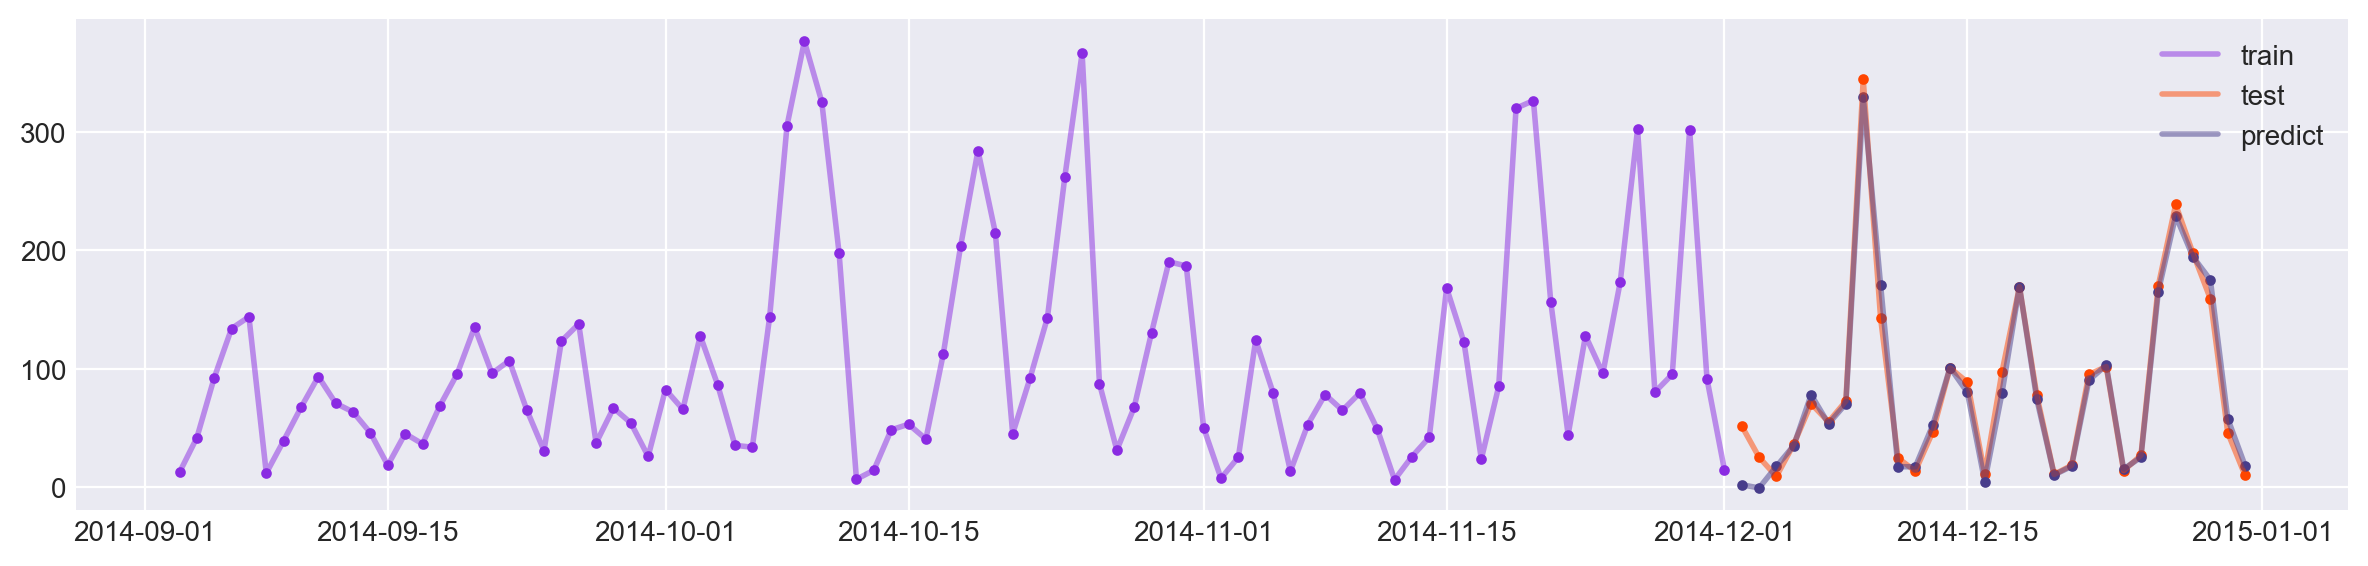

In [22]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [23]:
print(grid_search_results["params"])

{'l2_leaf_reg': 3}


In [24]:
del (
    train_data,
    test_data,
    train_data_feat,
    test_data_feat,
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 15

train_data, test_data = test_train_split(dataframe, test_size=WINDOW_LEN + 30)

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

x_window = np.concatenate([train_x, test_x])
y_window = np.concatenate([train_y, test_y])


x_window, y_window = window_data(x_window, y_window, window_len=WINDOW_LEN)

x_train_data, x_test_data = x_window[: -len(test_x)], x_window[-len(test_x) :]
y_train_data, y_test_data = y_window[: -len(test_x)], y_window[-len(test_x) :]

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

model = tf.keras.models.Sequential(
    [
        LSTM(128, input_shape=x_window.shape[-2:], dropout=0.0),
        Dense(128),
        Dense(128),
        Dense(1),
    ]
)

model.compile(optimizer="rmsprop", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=EPOCHS_,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/15
200/200 [==============================] - 12s 46ms/step - loss: 4570.5986 - mae: 49.5345 - val_loss: 2340.4849 - val_mae: 37.5175
Epoch 2/15
200/200 [==============================] - 8s 41ms/step - loss: 655.9919 - mae: 18.6504 - val_loss: 164.1129 - val_mae: 11.0224
Epoch 3/15
200/200 [==============================] - 8s 42ms/step - loss: 160.7223 - mae: 9.8521 - val_loss: 88.7046 - val_mae: 7.3960
Epoch 4/15
200/200 [==============================] - 8s 42ms/step - loss: 80.5029 - mae: 7.1906 - val_loss: 106.7537 - val_mae: 8.1477
Epoch 5/15
200/200 [==============================] - 8s 41ms/step - loss: 57.7961 - mae: 6.0319 - val_loss: 72.0258 - val_mae: 5.9300
Epoch 6/15
200/200 [==============================] - 9s 43ms/step - loss: 43.2681 - mae: 5.0652 - val_loss: 43.2278 - val_mae: 4.5221
Epoch 7/15
200/200 [==============================] - 8s 41ms/step - loss: 36.0842 - mae: 4.5846 - val_loss: 99.5440 - val_mae: 7.6007
Epoch 8/15
200/200 [======================

In [26]:
resultsDict[model_name] = evaluate(y_test_data.flatten(), yhat.flatten())

predictionsDF[model_name] = yhat.flatten()[-len(predictionsDF.index) :]

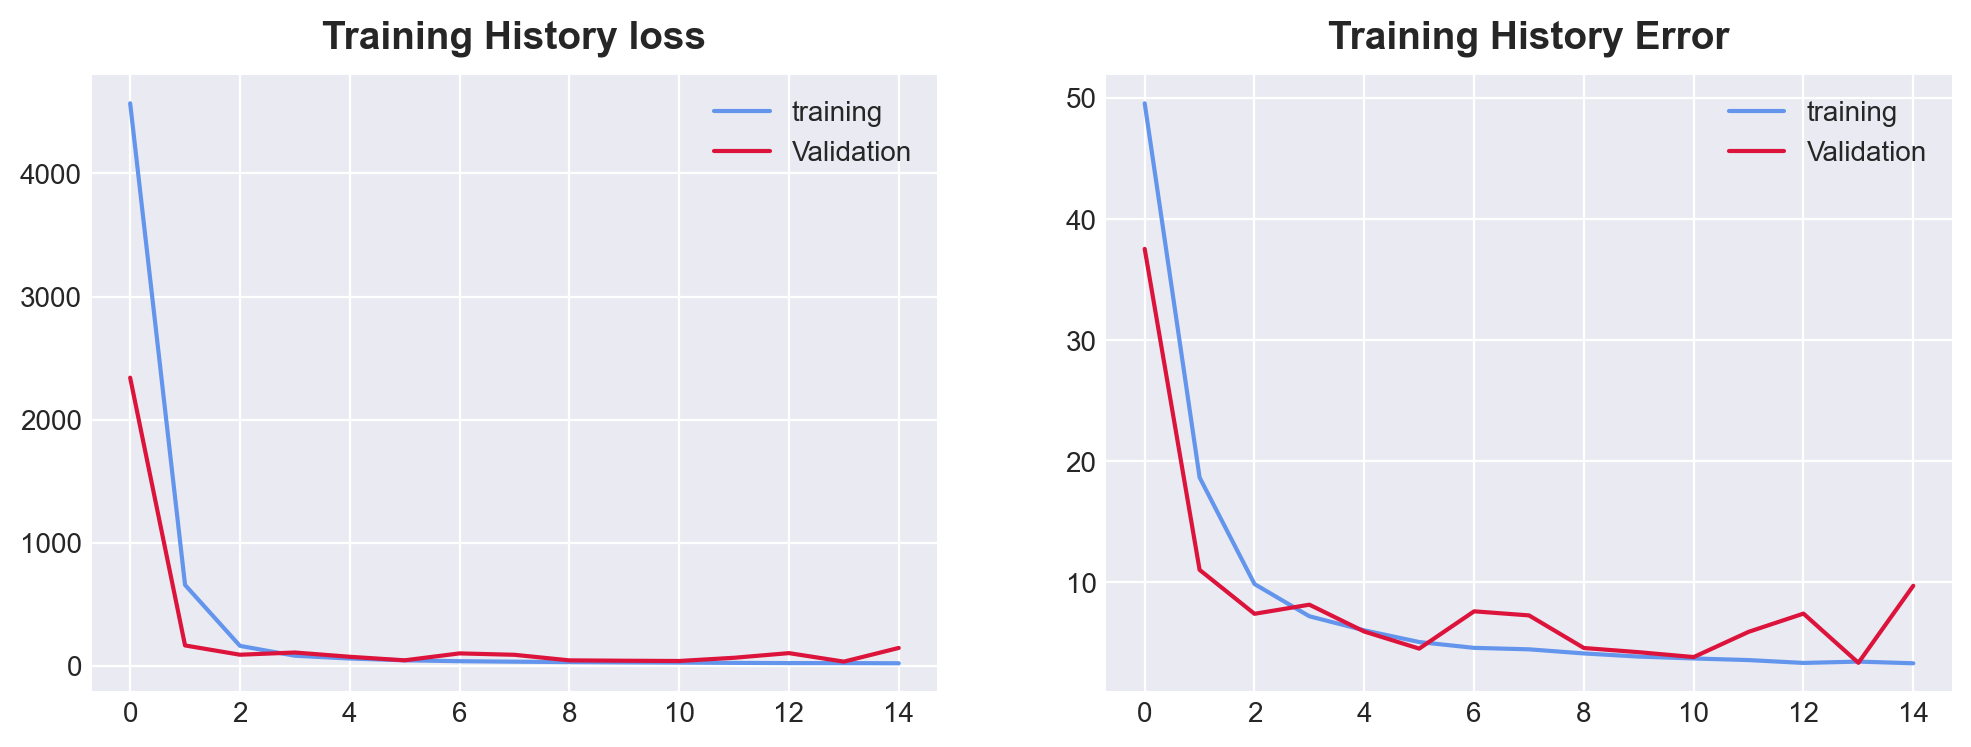

In [27]:
plot_tf_training_history(training_history)

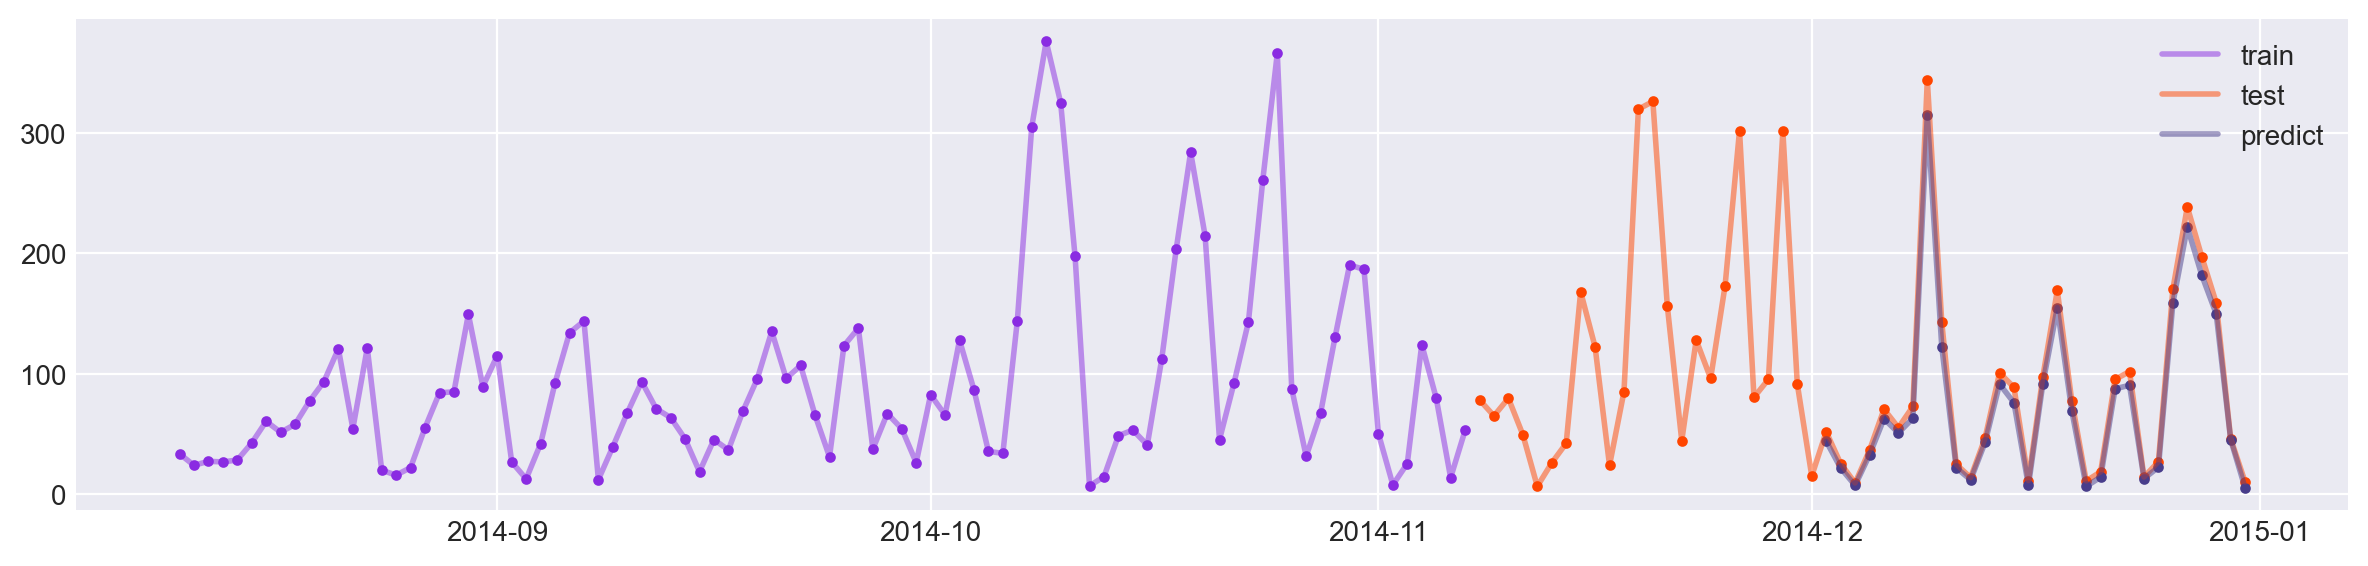

In [28]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [29]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,33.535417,3.719444,3.962822,13.176288,10.687308,10.514382,8.550885,9.712465
rmse,47.208150,14.803536,14.688441,19.954851,15.782649,16.615239,13.453255,11.994231
mape,0.984877,0.100347,0.106458,0.361265,0.264212,0.195491,0.215713,0.142861
r2,0.633723,0.963983,0.964541,0.934555,0.959061,0.954628,0.970254,0.981703


In [30]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,33.535417,47.208150,0.984877,0.633723
BayesianRidge,3.719444,14.803536,0.100347,0.963983
LassoCV,3.962822,14.688441,0.106458,0.964541
RandomForestRegressor,13.176288,19.954851,0.361265,0.934555
XGBRegressor,10.687308,15.782649,0.264212,0.959061
LGBMRegressor,10.514382,16.615239,0.195491,0.954628
CatBoostRegressor,8.550885,13.453255,0.215713,0.970254
LSTM_Dense,9.712465,11.994231,0.142861,0.981703


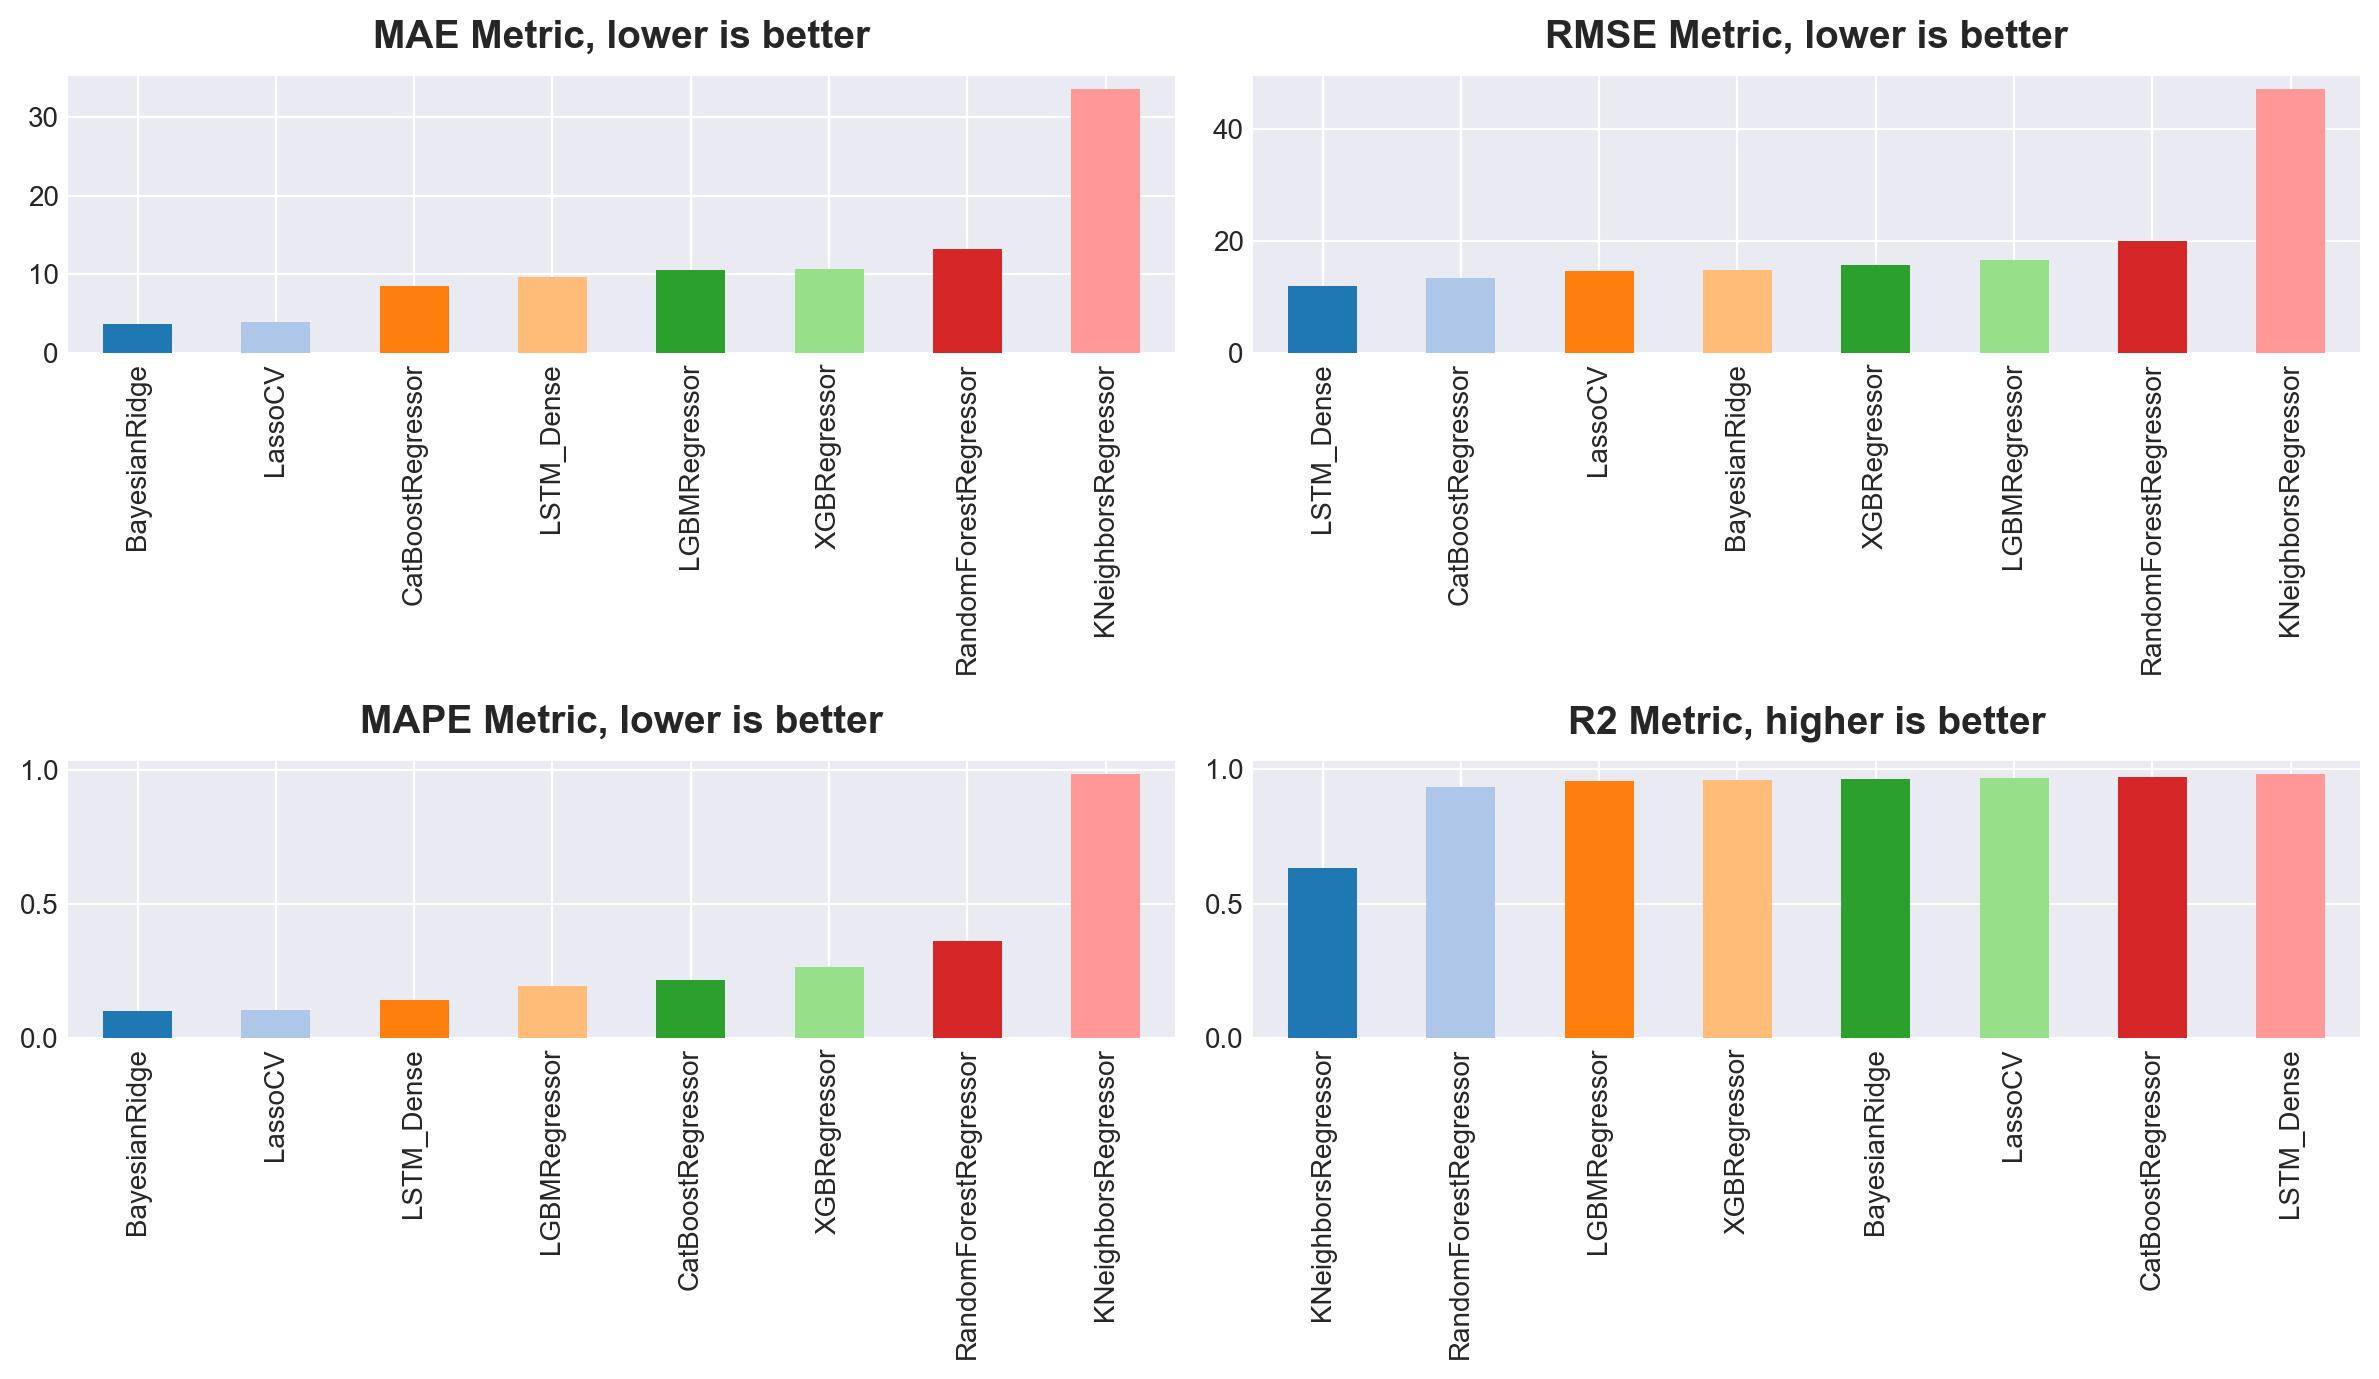

In [31]:
plot_metrics(resultsDF)

In [33]:
resultsDF_T = resultsDF.T.copy(deep=True)

resultsDF_T["Dataset"] = "Air_Polution"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"


if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Air_Polution"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Air_Polution"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)